In [1]:
import pandas as pd
import numpy as np
import time

INDEX = 'usedCarSkuId'
TARGET = 'listed_price'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/transformed-data/validation_2023-04-06_14-02-39.csv
/kaggle/input/transformed-data/test_2023-04-06_14-02-38.csv
/kaggle/input/transformed-data/train_2023-04-06_14-02-36.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/transformed-data/train_2023-04-06_14-02-36.csv', index_col=INDEX)
df_test = pd.read_csv('/kaggle/input/transformed-data/test_2023-04-06_14-02-38.csv', index_col=INDEX)
df_valid = pd.read_csv('/kaggle/input/transformed-data/validation_2023-04-06_14-02-39.csv', index_col=INDEX)

df_train.shape, df_test.shape, df_valid.shape

((28808, 49), (5084, 49), (3766, 49))

---

# Feature Engineering

In [3]:
from ast import literal_eval
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class FeatureEngineeringTransformations(BaseEstimator, TransformerMixin):
    """
    This class contains all the recommended feature engineering transformations for the dataset.

    Parameters
    ----------
        df: pd.DataFrame
            The dataframe to be transformed
        object_cols: list
            The list of columns that contain the car features like top_features, comfort_features, etc. that need to be transformed
    """

    def __init__(
            self,
            object_cols=None,
            target=TARGET
    ):
        self.feature_prices = None
        self.df = None
        if object_cols is None:
            object_cols = [
                'top_features',
                'comfort_features',
                'interior_features',
                'exterior_features',
                'safety_features'
            ]
        self.object_cols = object_cols
        self.target = target

    def _car_object_feature_dict(self) -> dict:
        unique_feature_scores = dict()
        for col in self.object_cols:
            for _, row in self.df.iterrows():
                feature_list = literal_eval(row[col])
                for feature in feature_list:
                    if feature in unique_feature_scores.keys():
                        unique_feature_scores[feature][1] += 1
                        unique_feature_scores[feature][0] += row[self.target]
                    else:
                        unique_feature_scores[feature] = [row[self.target], 1]

        return unique_feature_scores

    def _map_object_cols_to_scores(self, x: str) -> float:
        feature_list = literal_eval(x)
        feature_score = 0
        for feature in feature_list:
            if feature in self.feature_prices.keys():
                feature_score += self.feature_prices[feature][0] / self.feature_prices[feature][1]
            else:
                feature_score += 0
        return feature_score

    def _car_object_feature_transformation(self, df) -> pd.DataFrame:
        if self.feature_prices is None:
            raise Exception('Please fit the transformer first')

        for col in self.object_cols:
            df[f'{col}_score'] = df[col].apply(self._map_object_cols_to_scores)
            df.drop(col, axis=1, inplace=True)
            # Replace zero scores with nan
            df[f'{col}_score'] = df[f'{col}_score'].replace(0, np.nan)
        return df

    def fit(self, X: pd.DataFrame, y=None) -> 'FeatureEngineeringTransformations':
        self.df = X.copy()
        if y is not None:
            self.df[self.target] = y
        elif self.target not in X.columns.to_list() is None:
            raise ValueError('A target must be provided')
        self.feature_prices = self._car_object_feature_dict()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        check_is_fitted(self, 'feature_prices')

        # Transform the object columns to scores
        X = X.copy()
        X = self._car_object_feature_transformation(X)
        return X

---

# Training and Testing Data

In [4]:
train, test, valid = df_train.copy(), df_test.copy(), df_valid.copy()

# Do the feature engineering transformations
fe = FeatureEngineeringTransformations()

fe = fe.fit(train)
train = fe.transform(train)
test = fe.transform(test)
valid = fe.transform(valid)

train.shape, test.shape, valid.shape

((28808, 49), (5084, 49), (3766, 49))

In [5]:
X_train = train.drop(columns=[TARGET], axis=1)
y_train = train[TARGET]
X_test = test.drop(columns=[TARGET], axis=1)
y_test = test[TARGET]

X_train.shape, X_train.shape, X_test.shape, y_test.shape

((28808, 48), (28808, 48), (5084, 48), (5084,))

---

# Preprocessor

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import catboost
from sklearn.impute import SimpleImputer


numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
categorical_cols_with_nan = [col for col in categorical_cols if X_train[col].isnull().any()]

X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_test[categorical_cols] = X_test[categorical_cols].astype('category')

si = SimpleImputer(strategy='most_frequent', fill_value='missing')
X_train[categorical_cols_with_nan] = si.fit_transform(X_train[categorical_cols_with_nan])
X_test[categorical_cols_with_nan] = si.transform(X_test[categorical_cols_with_nan])

pool_train = catboost.Pool(X_train, y_train, cat_features=categorical_cols.to_list())
pool_test = catboost.Pool(X_test, cat_features=categorical_cols.to_list())
pool_test_for_eval = catboost.Pool(X_test, y_test, cat_features=categorical_cols.to_list())

---

# Intial Models

In [7]:
class TargetTransformedCBRegressor:
    def __init__(
        self, 
        loss='MAE', 
        n_estimators = 10000,
        early_stopping_rounds=200,
        transformation=np.log, 
        inverse_transformation=np.exp
    ):
        self.cb_model = catboost.CatBoostRegressor(
            learning_rate = 0.08,
            depth = 5,
            l2_leaf_reg = 4,
            loss_function = loss,
            bootstrap_type = 'Bernoulli',
            subsample = 0.5,
            random_seed = 42,
            allow_writing_files = False,
            verbose = 100,
            n_estimators = 5000,
            early_stopping_rounds=200,
        )
        self.loss = loss
        self.transformation = transformation
        self.inverse_transformation = inverse_transformation
    
    def train(self, X_train, y_train, eval_X, eval_y):
        categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
        pool_train = catboost.Pool(X_train, self.transformation(y_train), cat_features=categorical_cols.to_list())
        pool_test_for_eval = catboost.Pool(eval_X, self.transformation(eval_y), cat_features=categorical_cols.to_list())
        self.cb_model.fit(pool_train, eval_set=pool_test_for_eval)
        return self
    
    def predict(self, pool_test):
        y_pred = self.cb_model.predict(pool_test)
        return self.inverse_transformation(y_pred)

In [55]:
import random
from matplotlib import pyplot as plt
import seaborn as sns

def plot_learning_curve(cb_model, loss):
    sns.set_style('darkgrid')
    sns.set_context('paper', font_scale=1)
    plt.rcParams['figure.dpi'] = 300
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    pallete = sns.color_palette("icefire", 15)
    color1 = random.choice(pallete)
    color2 = random.choice(pallete)

    plot = sns.lineplot(cb_model.cb_model.evals_result_['learn'][loss], label='Train', linewidth=1.75, color=color1)
    plot = sns.lineplot(cb_model.cb_model.evals_result_['validation'][loss], label='Validation', linewidth=1.75, color=color2)
    # plot.set_ylim([40000, 2e5])
    plot.set_xlabel('Iterations')
    plot.set_ylabel('Loss Metric')
    plot.set_title('Catboost Loss v/s Itarations')
    plt.show()

## MAE Objective

### Training

In [57]:
cb_model_mae = TargetTransformedCBRegressor()
cb_model_mae.train(X_train, y_train, eval_X=X_test, eval_y=y_test)

0:	learn: 0.5941589	test: 0.5833832	best: 0.5833832 (0)	total: 52.1ms	remaining: 4m 20s
100:	learn: 0.1449402	test: 0.1436146	best: 0.1436146 (100)	total: 5.12s	remaining: 4m 8s
200:	learn: 0.1264208	test: 0.1253035	best: 0.1253035 (200)	total: 10.3s	remaining: 4m 5s
300:	learn: 0.1186250	test: 0.1186517	best: 0.1186517 (300)	total: 15.8s	remaining: 4m 7s
400:	learn: 0.1139423	test: 0.1150435	best: 0.1150435 (400)	total: 20.9s	remaining: 3m 59s
500:	learn: 0.1109054	test: 0.1128684	best: 0.1128684 (500)	total: 26s	remaining: 3m 53s
600:	learn: 0.1086299	test: 0.1114320	best: 0.1114320 (600)	total: 31s	remaining: 3m 47s
700:	learn: 0.1068848	test: 0.1105082	best: 0.1105082 (700)	total: 36s	remaining: 3m 40s
800:	learn: 0.1054128	test: 0.1097637	best: 0.1097637 (800)	total: 41.1s	remaining: 3m 35s
900:	learn: 0.1041588	test: 0.1091891	best: 0.1091891 (900)	total: 46.5s	remaining: 3m 31s
1000:	learn: 0.1030394	test: 0.1086542	best: 0.1086504 (999)	total: 51.7s	remaining: 3m 26s
1100:	lear

### Testing 

In [60]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Make predictions on the test data
y_pred = cb_model_mae.predict(pool_test)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MAPE: 0.10673296923295818
MAE: 75390.69975353133


### Residuals

In [61]:
residuals = (y_test-y_pred)
residuals_ratio = residuals/y_test
residuals_percent = residuals_ratio * 100
abs(residuals_percent).describe()

count    5084.000000
mean       10.673297
std        11.301673
min         0.001900
25%         3.319108
50%         7.445908
75%        14.110042
max       120.399096
Name: listed_price, dtype: float64

### Residual Plots

Text(0, 0.5, 'Residuals in percentage')

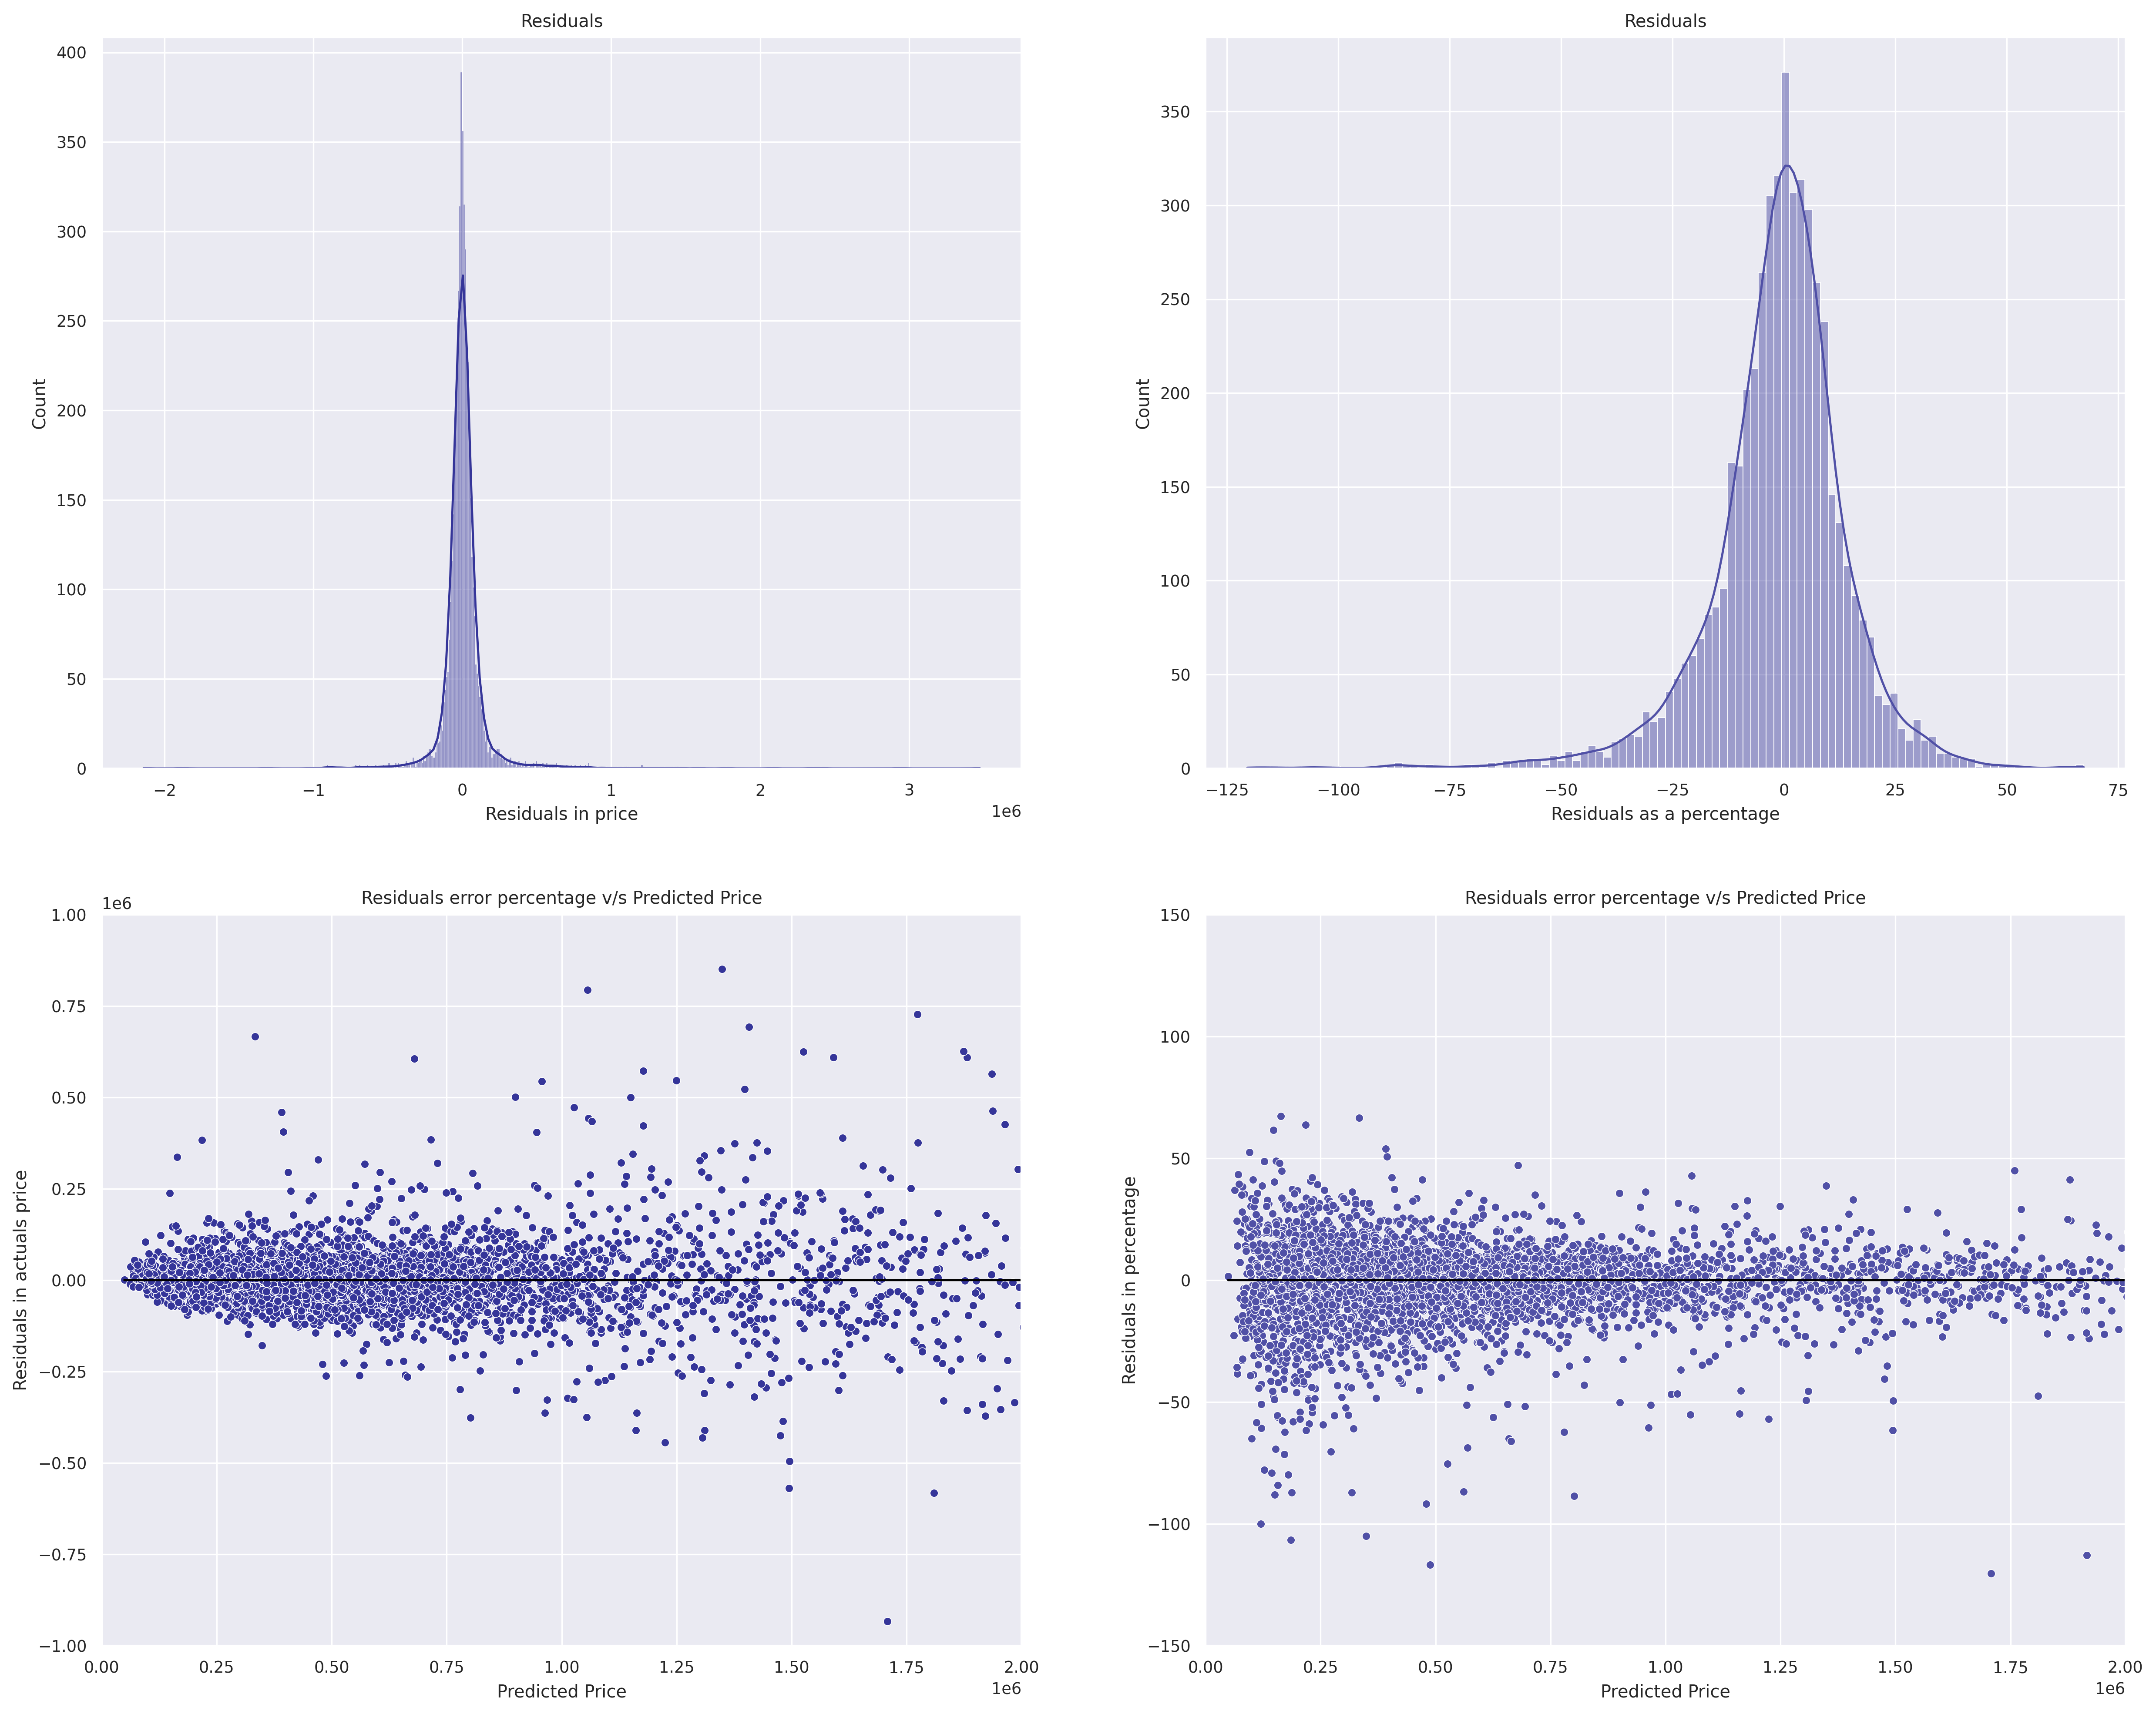

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns
import random

pallete = sns.light_palette("navy", reverse=True, n_colors=10)
color1 = pallete[2]
color2 = pallete[3]

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2, 2, figsize=(20, 16))


# Plot the residuals in a histogram in subplot 1
plot0 = sns.histplot(x=residuals, kde=True, ax=ax[0][0], color=color1)
ax[0][0].set_title('Residuals')
ax[0][0].set_xlabel('Residuals in price')
ax[0][0].set_ylabel('Count')


# Plot the residuals percentage in a histogram in subplot 2
plot1 = sns.histplot(x=residuals_percent, kde=True, ax=ax[0][1], color=color2)
ax[0][1].set_title('Residuals')
ax[0][1].set_xlabel('Residuals as a percentage')
ax[0][1].set_ylabel('Count')


# Plot the residual along the index in a reg plot in subplot 3
plot2 = sns.scatterplot(x=y_pred, y=residuals, s=20, ax=ax[1][0], color=color1)
sns.lineplot(x=y_pred, y=0, ax=ax[1][0], color='black')
plot2.set_xlim([0, 2e6])
plot2.set_ylim([-1e6, 1e6])

ax[1][0].set_title('Residuals error percentage v/s Predicted Price')
ax[1][0].set_xlabel('Predicted Price')
ax[1][0].set_ylabel('Residuals in actuals price')


# Plot the residual along the index in a reg plot in subplot 3
plot3 = sns.scatterplot(x=y_pred, y=residuals_percent, s=20, ax=ax[1][1], color=color2)
sns.lineplot(x=y_pred, y=0, ax=ax[1][1], color='black')
plot3.set_xlim([0, 2e6])
plot3.set_ylim([-150, 150])

ax[1][1].set_title('Residuals error percentage v/s Predicted Price')
ax[1][1].set_xlabel('Predicted Price')
ax[1][1].set_ylabel('Residuals in percentage')

### Feature Importances

Text(0.5, 1.0, 'Feature Importance')

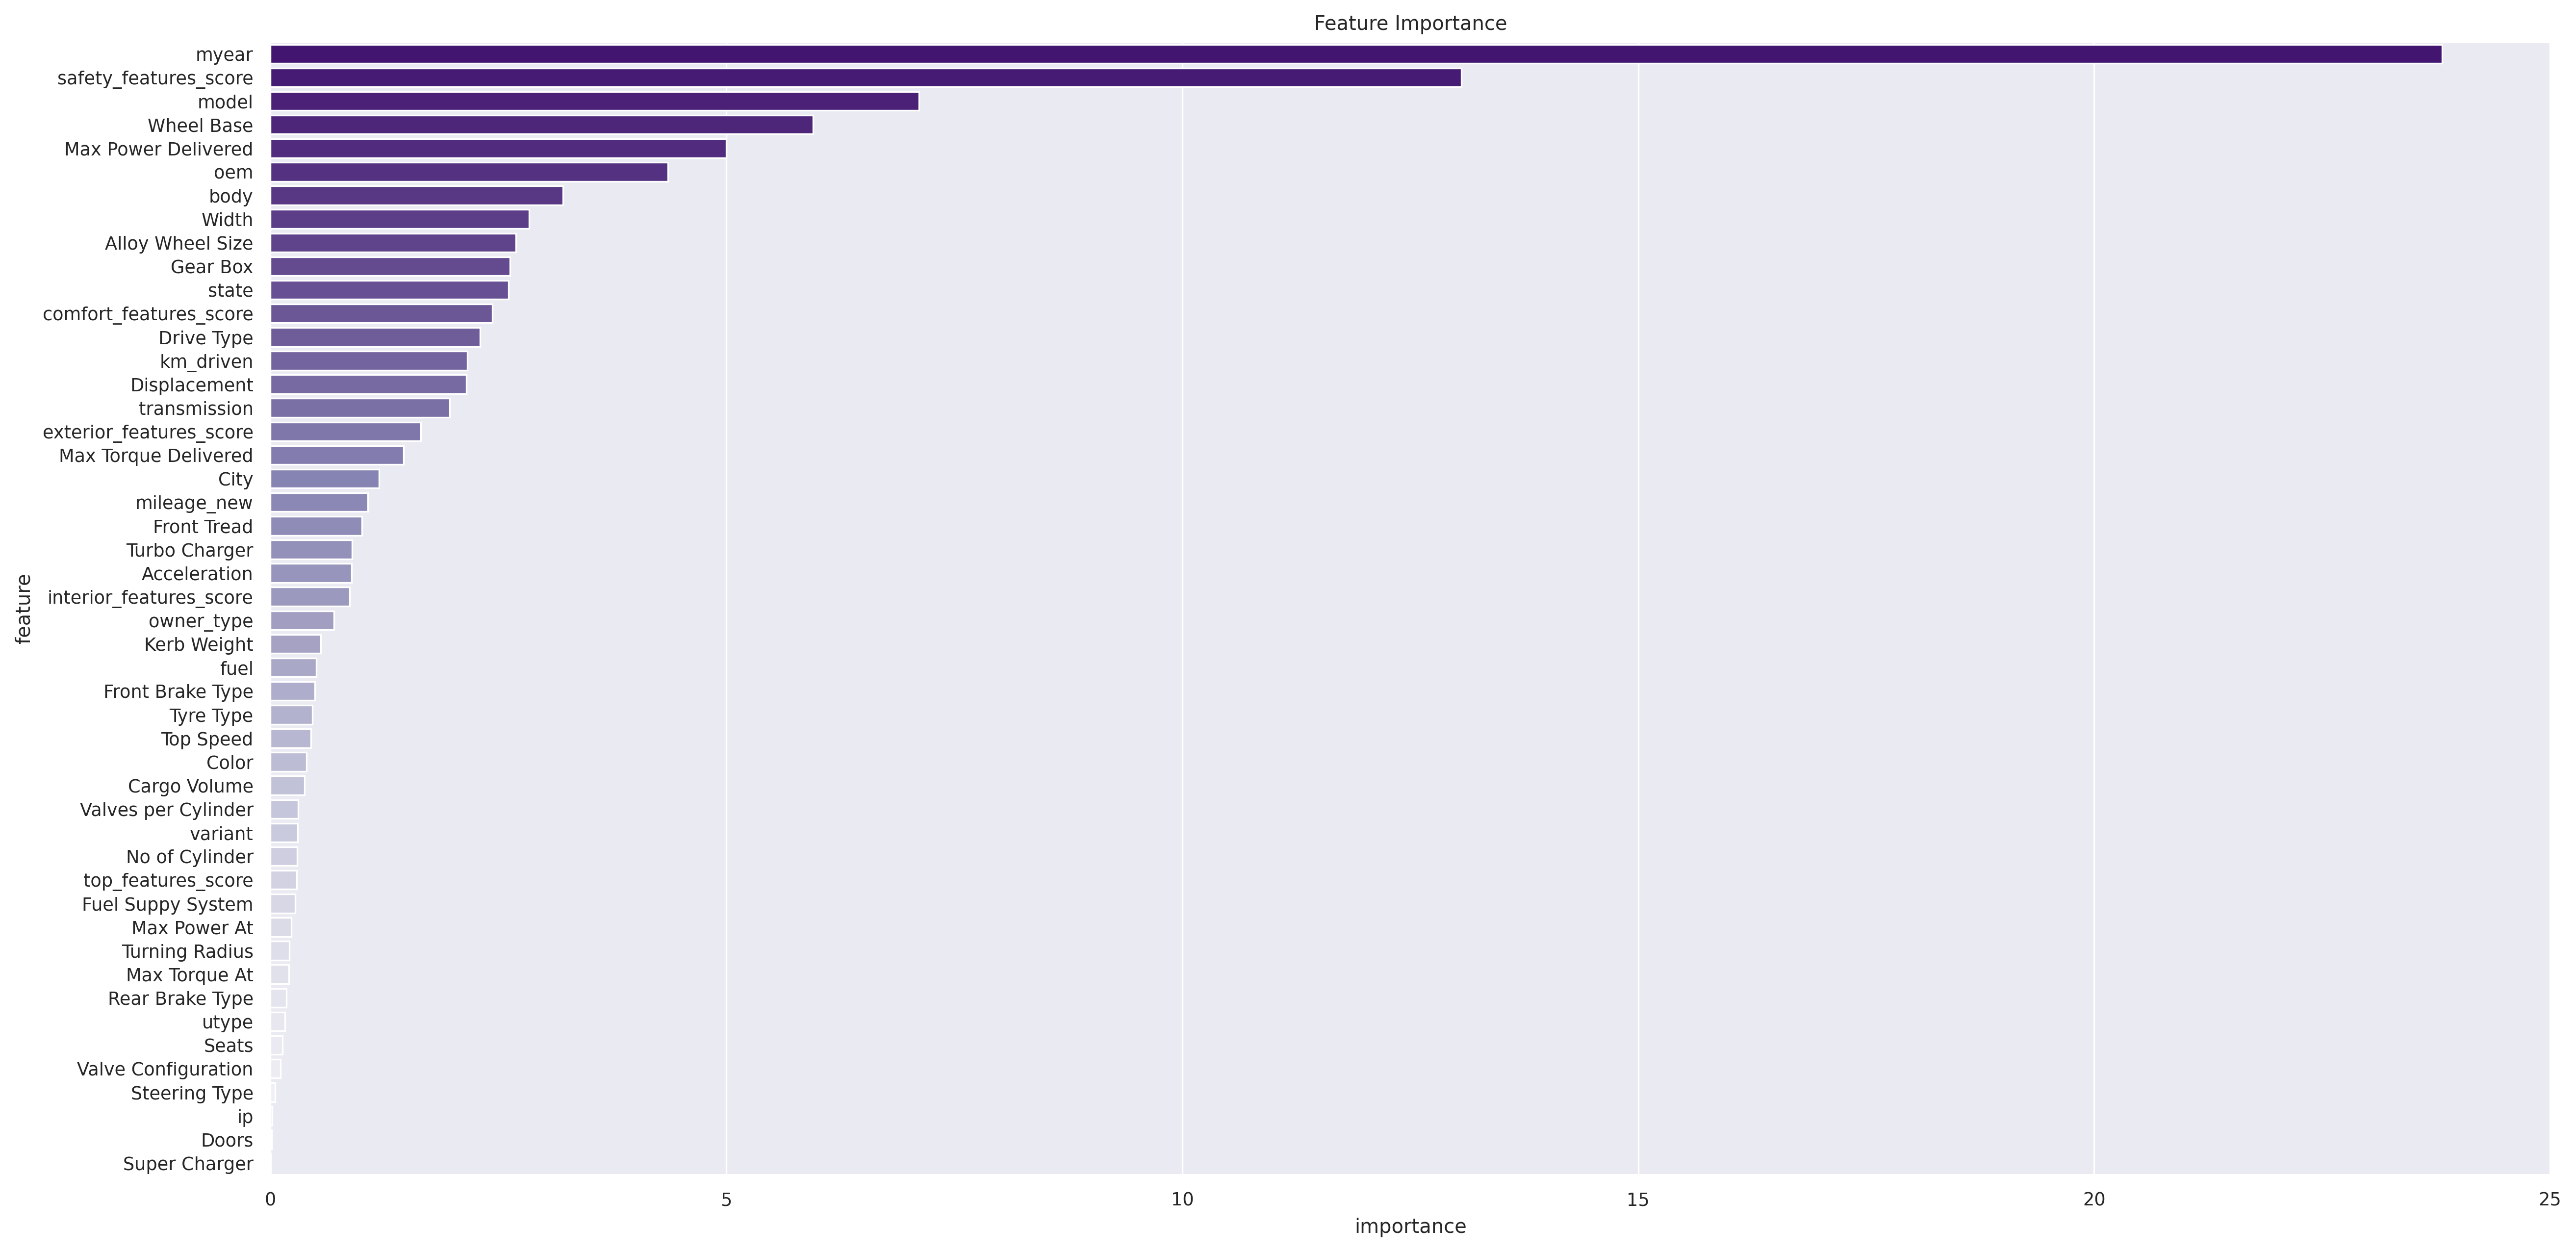

In [63]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': cb_model_mae.cb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

palette = sns.color_palette("Purples_r", n_colors=50)
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(x='importance', y='feature', data=feature_importance, palette=palette, ax=ax)
# ax.set_xticklabels(feature_importance['feature'], rotation=45, horizontalalignment='right')
ax.set_title('Feature Importance')

### SHAP interpretation

In [64]:
import shap

pool_shap_test = catboost.Pool(X_test, cat_features=[col for col in X_test.select_dtypes(include=['object', 'category']).columns])
shap_values = cb_model_mae_cheap.cb_model.get_feature_importance(pool_shap_test, type="ShapValues")

expected_value = shap_values[0,-1]
shap_value = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_value[0,:], X_test.iloc[0,:])

In [65]:
# explainer = shap.TreeExplainer(cb_model_mae_cheap.cb_model)
shap.force_plot(shap_values[0:10,-1], shap_values[0:10,:], X_test.iloc[0:10,:])

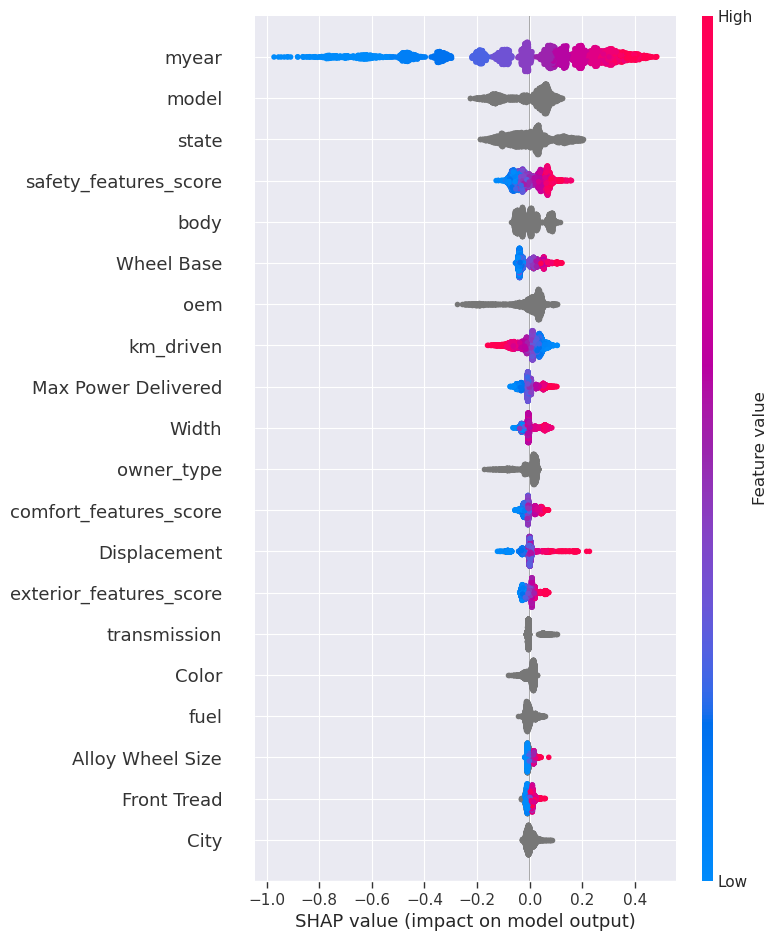

In [66]:
plt.rcParams['figure.dpi'] = 100
sns.set_style('darkgrid')
shap.summary_plot(shap_values[:,:-1], X_test)

---

## RMSEWithUncertainty Model

### Training

In [67]:
cb_model_uncertain = TargetTransformedCBRegressor(loss='RMSEWithUncertainty', early_stopping_rounds=300)
cb_model_uncertain.train(X_train, y_train, eval_X=X_test, eval_y=y_test)

0:	learn: 1.1150751	test: 1.0988755	best: 1.0988755 (0)	total: 67.3ms	remaining: 5m 36s
100:	learn: -0.2143003	test: -0.2256835	best: -0.2256835 (100)	total: 7.25s	remaining: 5m 51s
200:	learn: -0.3379024	test: -0.3353391	best: -0.3353391 (200)	total: 14.8s	remaining: 5m 54s
300:	learn: -0.4001135	test: -0.3830669	best: -0.3830669 (300)	total: 22.9s	remaining: 5m 57s
400:	learn: -0.4433337	test: -0.4163058	best: -0.4163058 (400)	total: 30.1s	remaining: 5m 44s
500:	learn: -0.4759422	test: -0.4365144	best: -0.4365144 (500)	total: 38.1s	remaining: 5m 41s
600:	learn: -0.5064987	test: -0.4543710	best: -0.4543710 (600)	total: 46.5s	remaining: 5m 40s
700:	learn: -0.5278401	test: -0.4657710	best: -0.4657710 (700)	total: 54s	remaining: 5m 31s
800:	learn: -0.5514552	test: -0.4735442	best: -0.4736603 (794)	total: 1m 1s	remaining: 5m 20s
900:	learn: -0.5702630	test: -0.4802289	best: -0.4802289 (900)	total: 1m 8s	remaining: 5m 11s
1000:	learn: -0.5886285	test: -0.4862936	best: -0.4862936 (1000)	tot

### Testing

In [73]:
# Make predictions on the test data
y_pred_with_var = cb_model_uncertain.predict(pool_test)
y_pred = y_pred_with_var[:,0]
# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MAPE: 0.11897512288135226
MAE: 87516.8029530735


### Residuals

In [74]:
residuals = (y_test-y_pred)
residuals_ratio = residuals/y_test
residuals_percent = residuals_ratio * 100
abs(residuals_percent).describe()

count    5084.000000
mean       11.897512
std        11.919530
min         0.001527
25%         3.953068
50%         8.571686
75%        15.833871
max       135.252514
Name: listed_price, dtype: float64

### Residual Plots

Text(0, 0.5, 'Residuals in percentage')

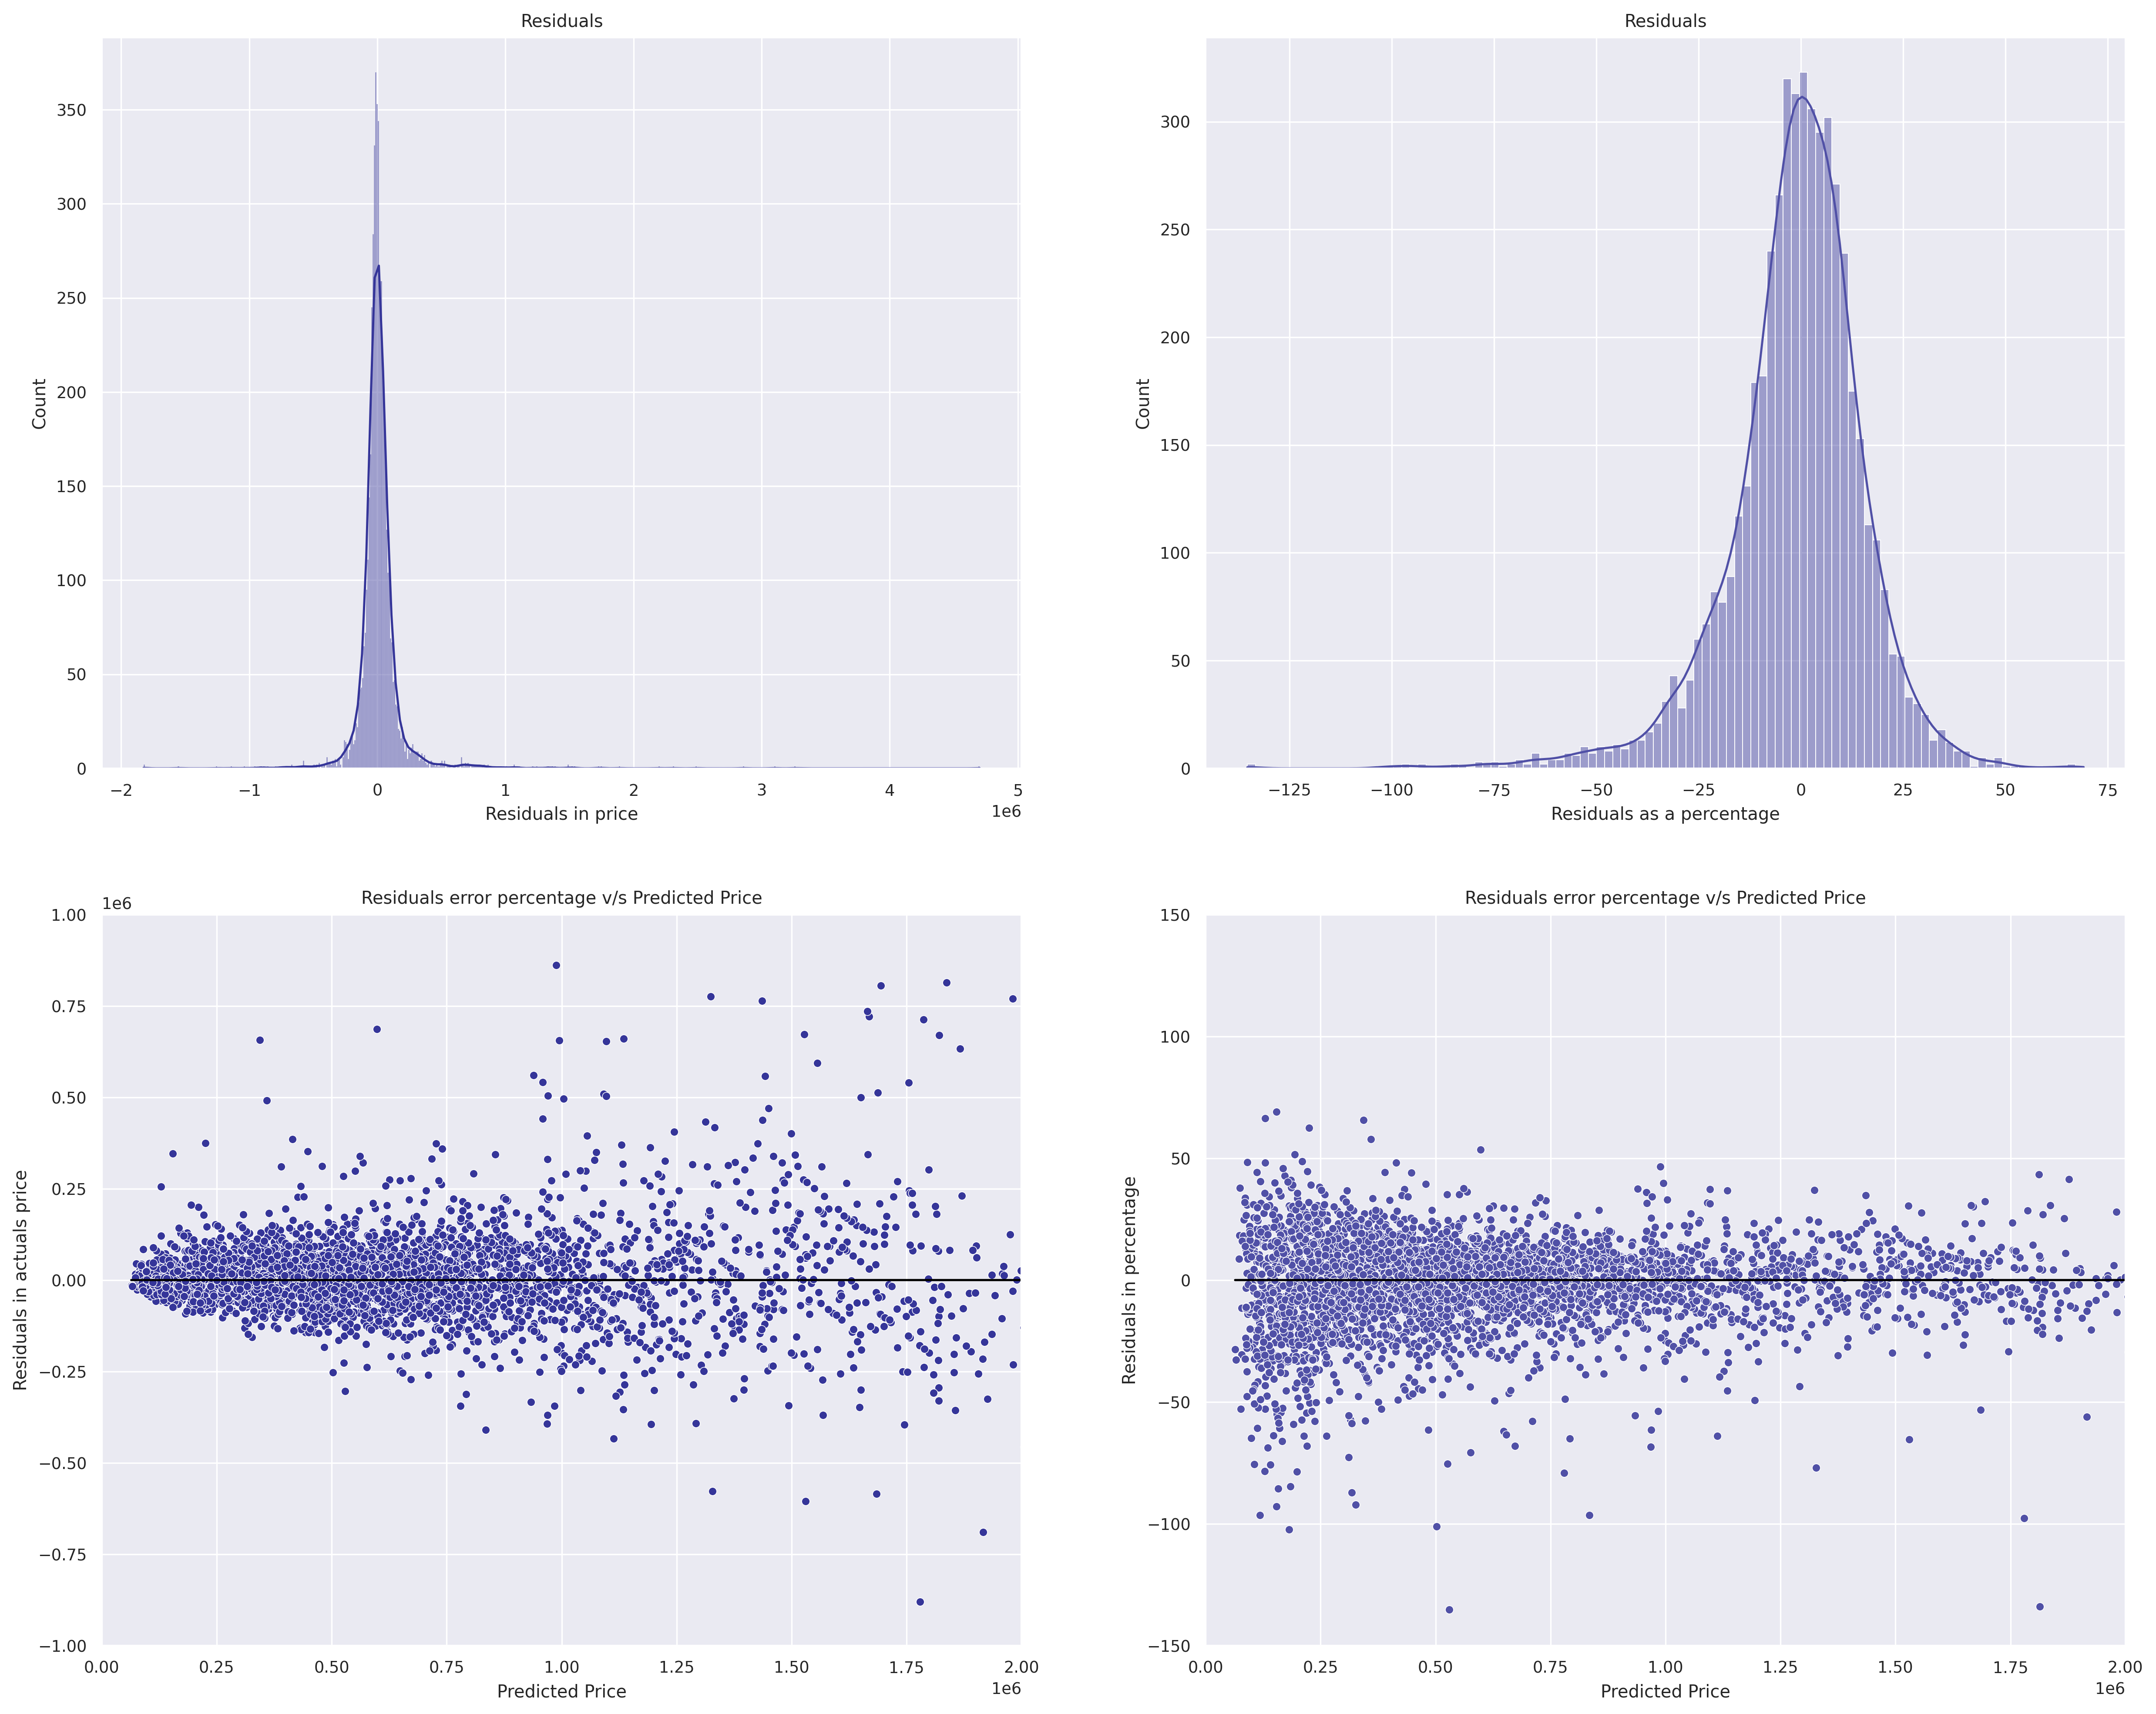

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns
import random

pallete = sns.light_palette("navy", reverse=True, n_colors=10)
color1 = pallete[2]
color2 = pallete[3]

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2, 2, figsize=(20, 16))


# Plot the residuals in a histogram in subplot 1
plot0 = sns.histplot(x=residuals, kde=True, ax=ax[0][0], color=color1)
ax[0][0].set_title('Residuals')
ax[0][0].set_xlabel('Residuals in price')
ax[0][0].set_ylabel('Count')


# Plot the residuals percentage in a histogram in subplot 2
plot1 = sns.histplot(x=residuals_percent, kde=True, ax=ax[0][1], color=color2)
ax[0][1].set_title('Residuals')
ax[0][1].set_xlabel('Residuals as a percentage')
ax[0][1].set_ylabel('Count')


# Plot the residual along the index in a reg plot in subplot 3
plot2 = sns.scatterplot(x=y_pred, y=residuals, s=20, ax=ax[1][0], color=color1)
sns.lineplot(x=y_pred, y=0, ax=ax[1][0], color='black')
plot2.set_xlim([0, 2e6])
plot2.set_ylim([-1e6, 1e6])

ax[1][0].set_title('Residuals error percentage v/s Predicted Price')
ax[1][0].set_xlabel('Predicted Price')
ax[1][0].set_ylabel('Residuals in actuals price')


# Plot the residual along the index in a reg plot in subplot 3
plot3 = sns.scatterplot(x=y_pred, y=residuals_percent, s=20, ax=ax[1][1], color=color2)
sns.lineplot(x=y_pred, y=0, ax=ax[1][1], color='black')
plot3.set_xlim([0, 2e6])
plot3.set_ylim([-150, 150])

ax[1][1].set_title('Residuals error percentage v/s Predicted Price')
ax[1][1].set_xlabel('Predicted Price')
ax[1][1].set_ylabel('Residuals in percentage')

### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

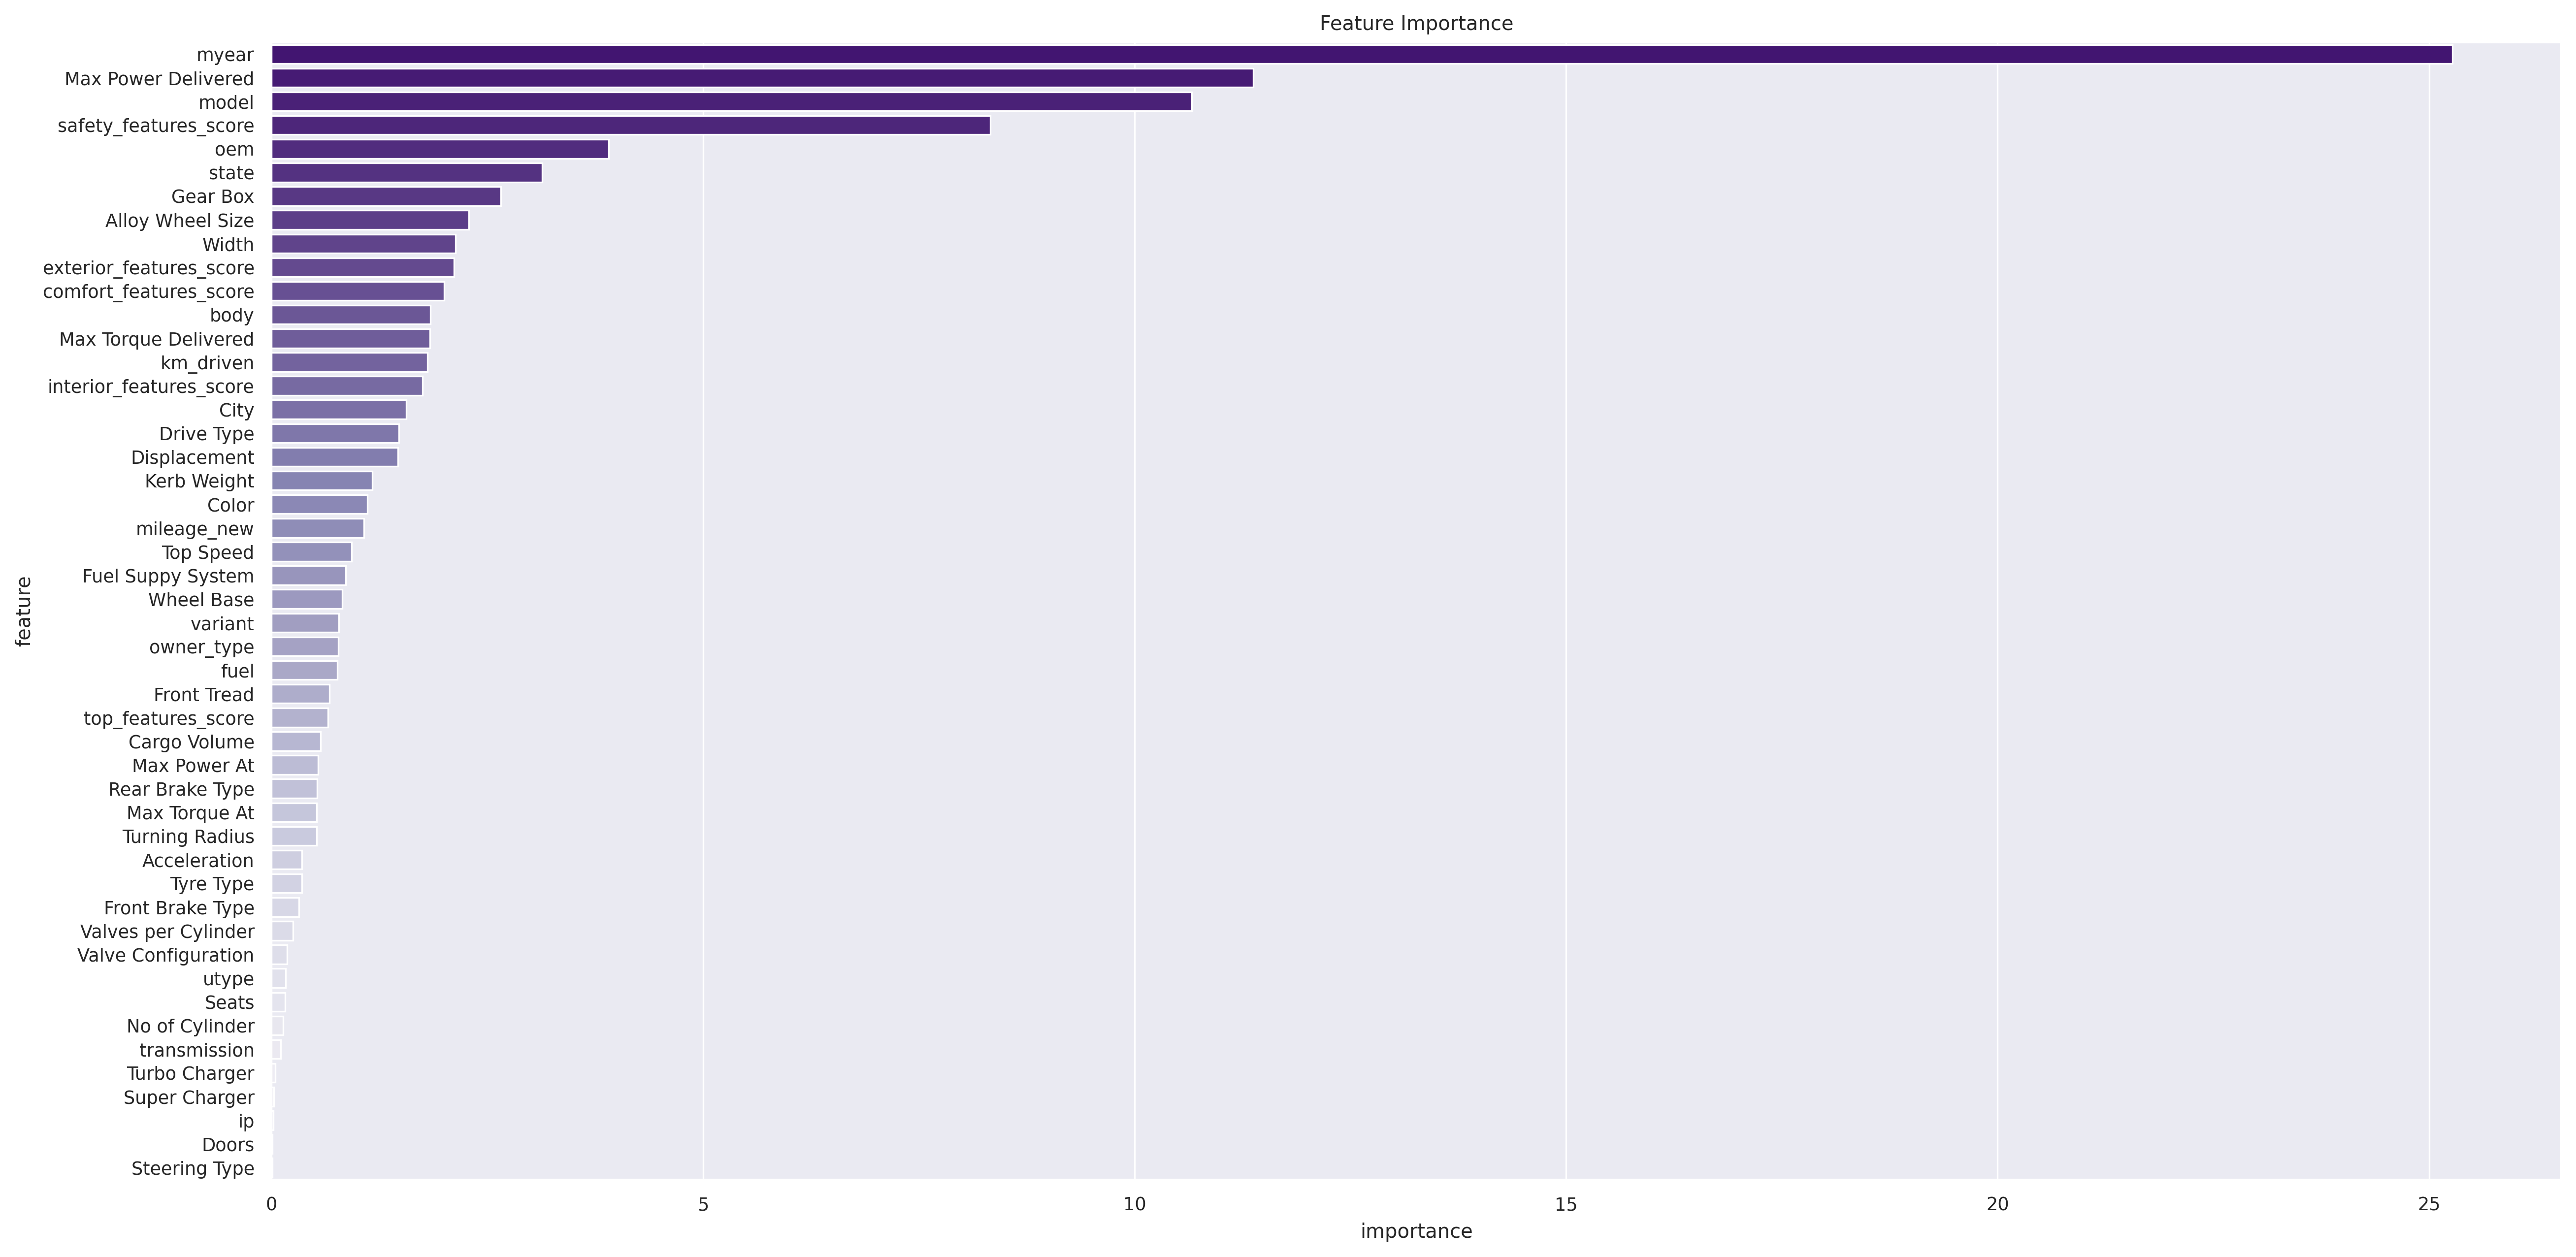

In [71]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': cb_model_uncertain.cb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

palette = sns.color_palette("Purples_r", n_colors=50)
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(x='importance', y='feature', data=feature_importance, palette=palette, ax=ax)
# ax.set_xticklabels(feature_importance['feature'], rotation=45, horizontalalignment='right')
ax.set_title('Feature Importance')

---

## MSE Model

### Training

In [77]:
cb_model_mse = TargetTransformedCBRegressor(loss='RMSE')
cb_model_mse.train(X_train, y_train, eval_X=X_test, eval_y=y_test)

0:	learn: 0.7691290	test: 0.7549742	best: 0.7549742 (0)	total: 56.5ms	remaining: 4m 42s
100:	learn: 0.1948303	test: 0.1911641	best: 0.1911641 (100)	total: 4.67s	remaining: 3m 46s
200:	learn: 0.1751402	test: 0.1720621	best: 0.1720621 (200)	total: 9.97s	remaining: 3m 57s
300:	learn: 0.1665634	test: 0.1648151	best: 0.1648151 (300)	total: 14.9s	remaining: 3m 52s
400:	learn: 0.1607310	test: 0.1606088	best: 0.1606088 (400)	total: 19.6s	remaining: 3m 44s
500:	learn: 0.1569894	test: 0.1582809	best: 0.1582809 (500)	total: 24.4s	remaining: 3m 39s
600:	learn: 0.1542072	test: 0.1565679	best: 0.1565411 (598)	total: 29.1s	remaining: 3m 32s
700:	learn: 0.1518528	test: 0.1553806	best: 0.1553771 (697)	total: 33.9s	remaining: 3m 27s
800:	learn: 0.1495896	test: 0.1544800	best: 0.1544800 (800)	total: 39.3s	remaining: 3m 26s
900:	learn: 0.1478068	test: 0.1536600	best: 0.1536600 (900)	total: 44.6s	remaining: 3m 22s
1000:	learn: 0.1460387	test: 0.1531002	best: 0.1531002 (1000)	total: 49.7s	remaining: 3m 18s


### Testing

In [78]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Make predictions on the test data
y_pred = cb_model_mse.predict(pool_test)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MAPE: 0.10725334293860495
MAE: 75921.87241483353


### Residuals

In [79]:
residuals = (y_test-y_pred)
residuals_ratio = residuals/y_test
residuals_percent = residuals_ratio * 100
abs(residuals_percent).describe()

count    5084.000000
mean       10.725334
std        11.233844
min         0.001886
25%         3.518384
50%         7.594742
75%        14.136766
max       135.460134
Name: listed_price, dtype: float64

### Residual Plots

Text(0, 0.5, 'Residuals in percentage')

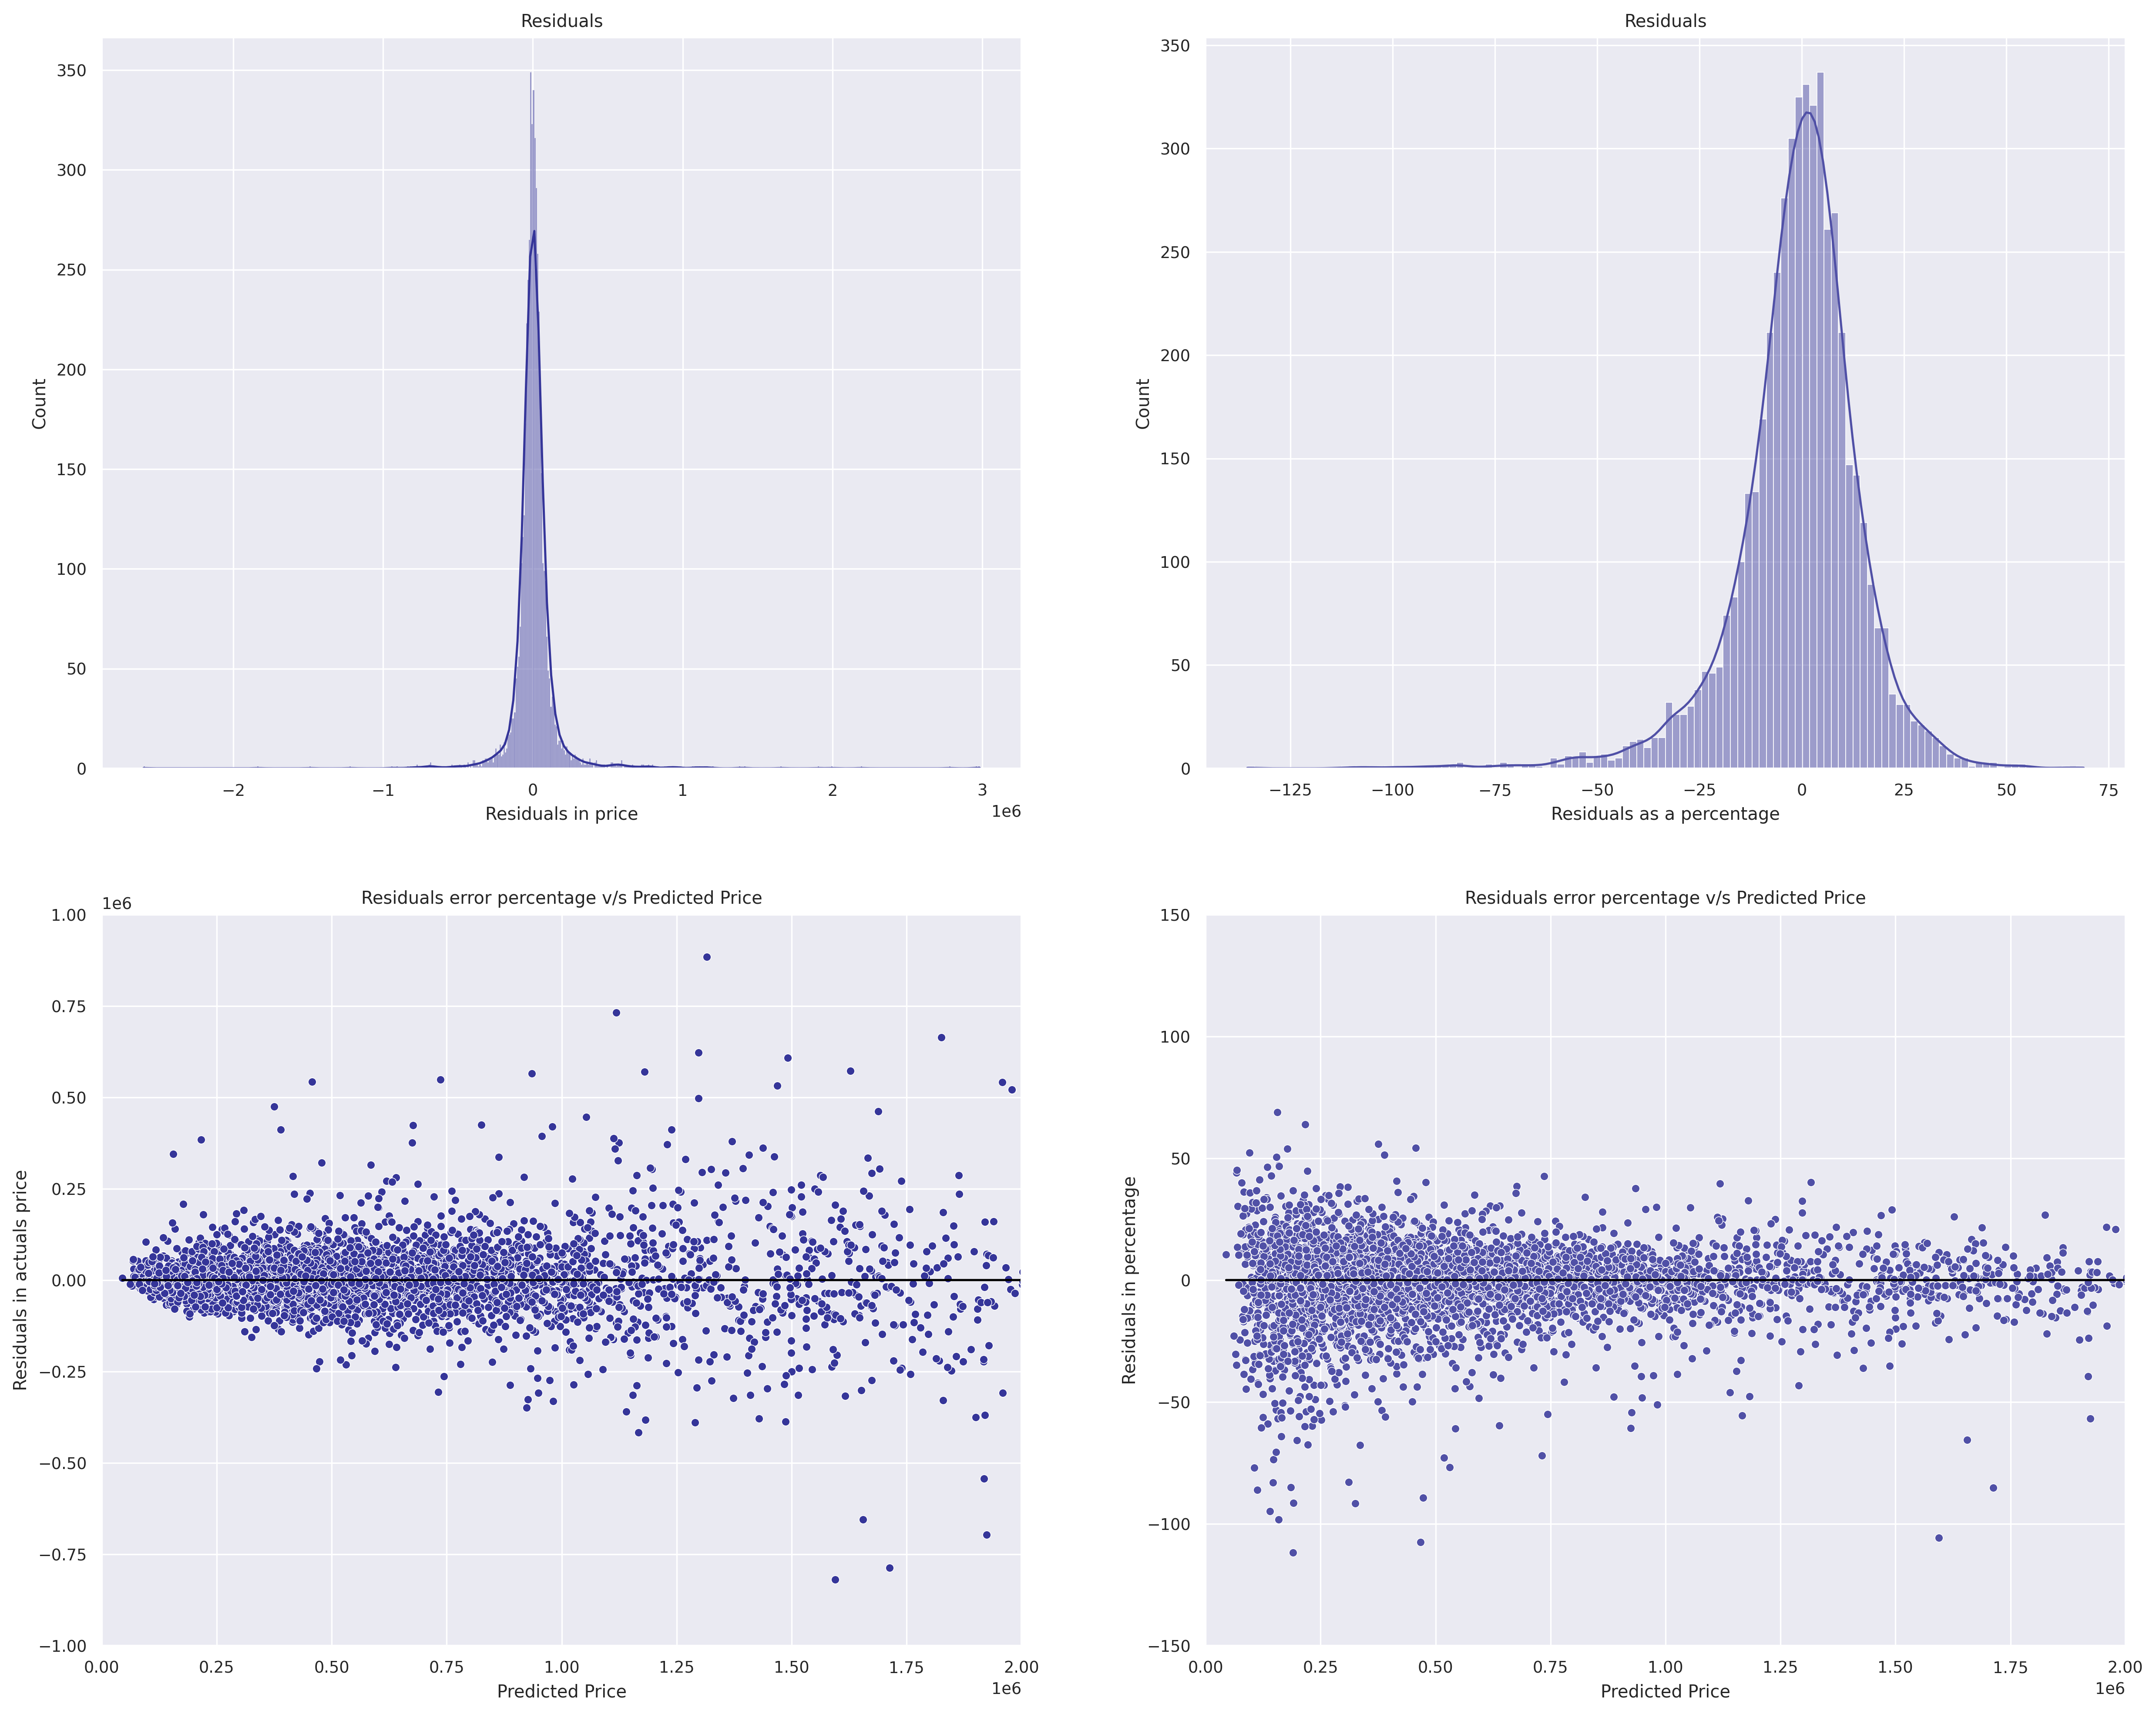

In [80]:
from matplotlib import pyplot as plt
import seaborn as sns
import random

pallete = sns.light_palette("navy", reverse=True, n_colors=10)
color1 = pallete[2]
color2 = pallete[3]

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2, 2, figsize=(20, 16))


# Plot the residuals in a histogram in subplot 1
plot0 = sns.histplot(x=residuals, kde=True, ax=ax[0][0], color=color1)
ax[0][0].set_title('Residuals')
ax[0][0].set_xlabel('Residuals in price')
ax[0][0].set_ylabel('Count')


# Plot the residuals percentage in a histogram in subplot 2
plot1 = sns.histplot(x=residuals_percent, kde=True, ax=ax[0][1], color=color2)
ax[0][1].set_title('Residuals')
ax[0][1].set_xlabel('Residuals as a percentage')
ax[0][1].set_ylabel('Count')


# Plot the residual along the index in a reg plot in subplot 3
plot2 = sns.scatterplot(x=y_pred, y=residuals, s=20, ax=ax[1][0], color=color1)
sns.lineplot(x=y_pred, y=0, ax=ax[1][0], color='black')
plot2.set_xlim([0, 2e6])
plot2.set_ylim([-1e6, 1e6])

ax[1][0].set_title('Residuals error percentage v/s Predicted Price')
ax[1][0].set_xlabel('Predicted Price')
ax[1][0].set_ylabel('Residuals in actuals price')


# Plot the residual along the index in a reg plot in subplot 3
plot3 = sns.scatterplot(x=y_pred, y=residuals_percent, s=20, ax=ax[1][1], color=color2)
sns.lineplot(x=y_pred, y=0, ax=ax[1][1], color='black')
plot3.set_xlim([0, 2e6])
plot3.set_ylim([-150, 150])

ax[1][1].set_title('Residuals error percentage v/s Predicted Price')
ax[1][1].set_xlabel('Predicted Price')
ax[1][1].set_ylabel('Residuals in percentage')

### Feature Importances

Text(0.5, 1.0, 'Feature Importance')

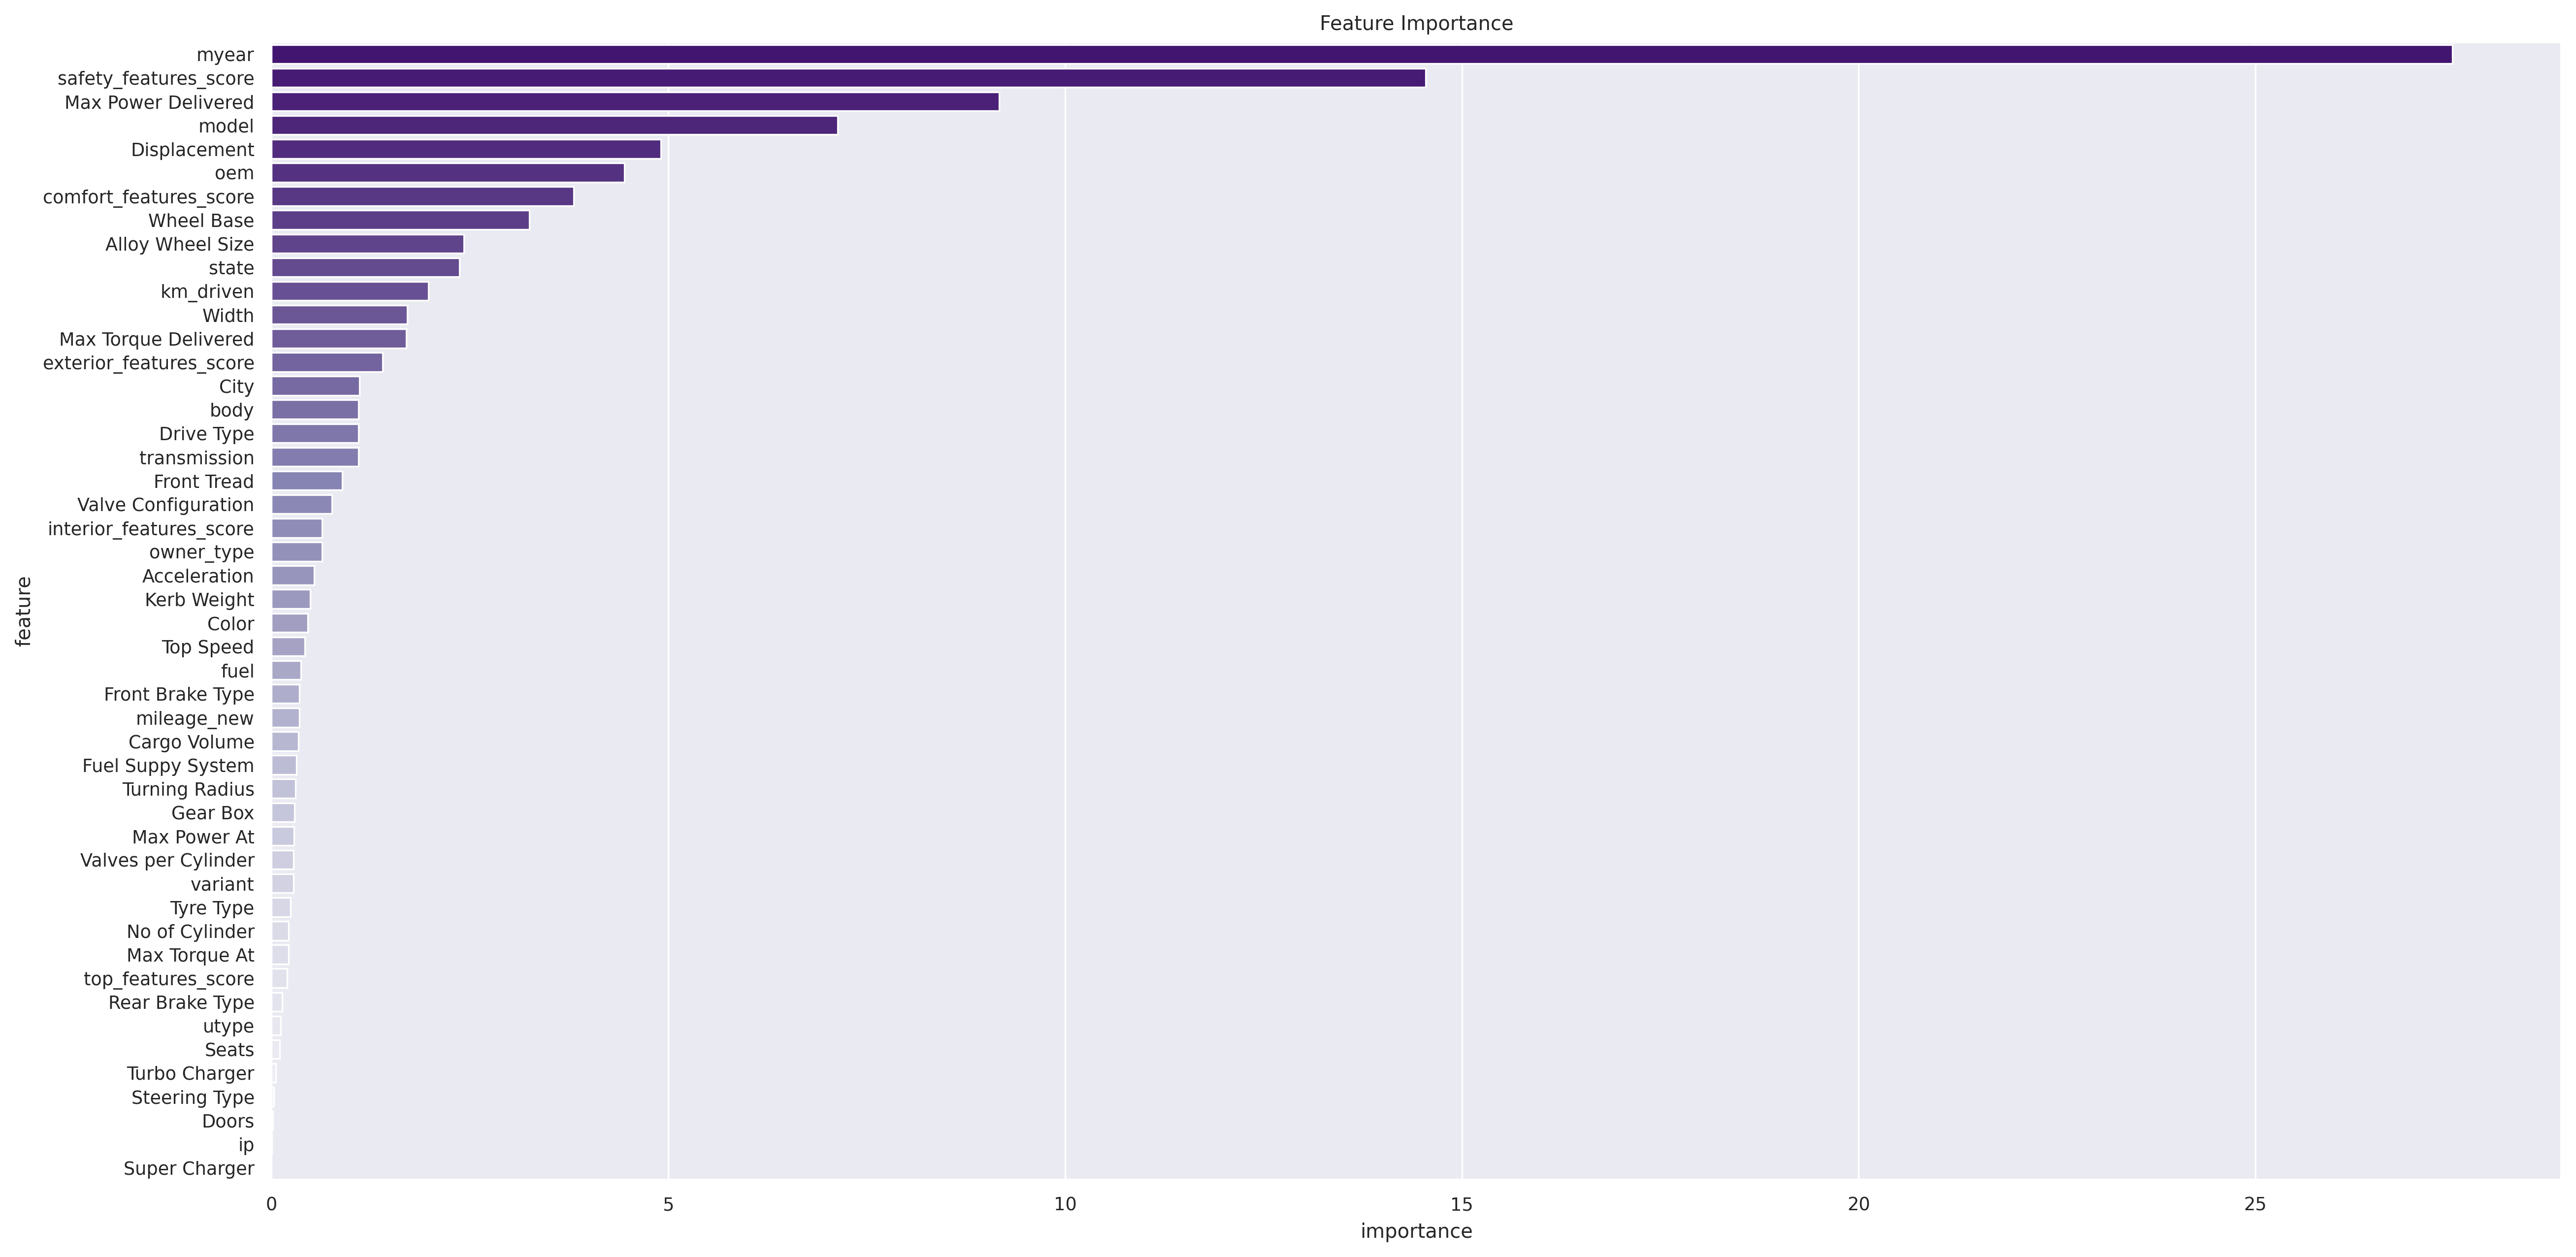

In [81]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': cb_model_mse.cb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

palette = sns.color_palette("Purples_r", n_colors=50)
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(x='importance', y='feature', data=feature_importance, palette=palette, ax=ax)
# ax.set_xticklabels(feature_importance['feature'], rotation=45, horizontalalignment='right')
ax.set_title('Feature Importance')

### SHAP interpretation

In [82]:
import shap

pool_shap_test = catboost.Pool(X_test, cat_features=[col for col in X_test.select_dtypes(include=['object', 'category']).columns])
shap_values = cb_model_mse.cb_model.get_feature_importance(pool_shap_test, type="ShapValues")

expected_value = shap_values[0,-1]
shap_value = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_value[0,:], X_test.iloc[0,:])

In [83]:
# explainer = shap.TreeExplainer(cb_model_mae_cheap.cb_model)
shap.force_plot(shap_values[0:10,-1], shap_values[0:10,:], X_test.iloc[0:10,:])

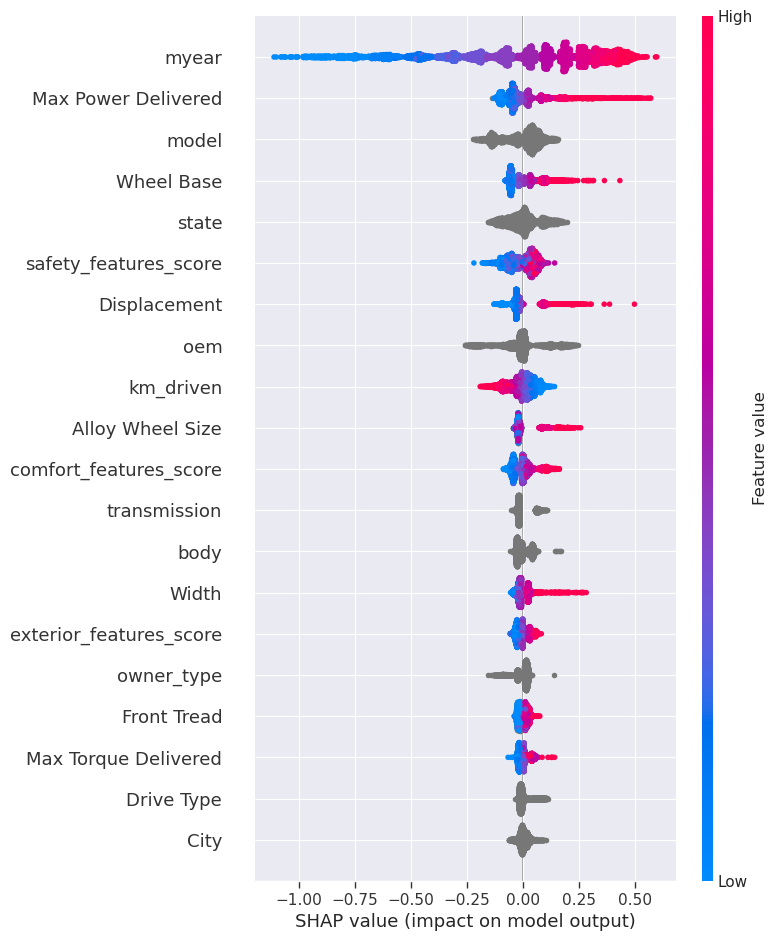

In [84]:
plt.rcParams['figure.dpi'] = 100
sns.set_style('darkgrid')
shap.summary_plot(shap_values[:,:-1], X_test)

---

## MAPE Model

### Training

In [85]:
cb_model_mape = TargetTransformedCBRegressor(loss='MAPE')
cb_model_mape.train(X_train, y_train, eval_X=X_test, eval_y=y_test)

0:	learn: 0.0450777	test: 0.0443569	best: 0.0443569 (0)	total: 88.4ms	remaining: 7m 21s
100:	learn: 0.0110162	test: 0.0108412	best: 0.0108412 (100)	total: 7.63s	remaining: 6m 10s
200:	learn: 0.0096934	test: 0.0095601	best: 0.0095601 (200)	total: 16.3s	remaining: 6m 27s
300:	learn: 0.0091202	test: 0.0090908	best: 0.0090908 (300)	total: 25.4s	remaining: 6m 37s
400:	learn: 0.0087814	test: 0.0088304	best: 0.0088304 (400)	total: 34.7s	remaining: 6m 38s
500:	learn: 0.0085604	test: 0.0086827	best: 0.0086827 (500)	total: 43.3s	remaining: 6m 29s
600:	learn: 0.0083862	test: 0.0085821	best: 0.0085821 (597)	total: 51.5s	remaining: 6m 16s
700:	learn: 0.0082510	test: 0.0085180	best: 0.0085180 (700)	total: 59.3s	remaining: 6m 3s
800:	learn: 0.0081326	test: 0.0084663	best: 0.0084663 (800)	total: 1m 6s	remaining: 5m 50s
900:	learn: 0.0080393	test: 0.0084332	best: 0.0084332 (900)	total: 1m 14s	remaining: 5m 41s
1000:	learn: 0.0079447	test: 0.0083948	best: 0.0083948 (1000)	total: 1m 23s	remaining: 5m 34s

### Testing

In [90]:
# Make predictions on the test data
y_pred = cb_model_mape.predict(pool_test)

# Calculate the MAPE and MAE
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAPE: {mape}")
print(f"MAE: {mae}")

MAPE: 0.10708006824340806
MAE: 77322.41603299274


### Residuals

In [91]:
residuals = (y_test-y_pred)
residuals_ratio = residuals/y_test
residuals_percent = residuals_ratio * 100
abs(residuals_percent).describe()

count    5084.000000
mean       10.708007
std        11.320301
min         0.008307
25%         3.400198
50%         7.458421
75%        14.155341
max       135.833055
Name: listed_price, dtype: float64

### Residual Plots

Text(0, 0.5, 'Residuals in percentage')

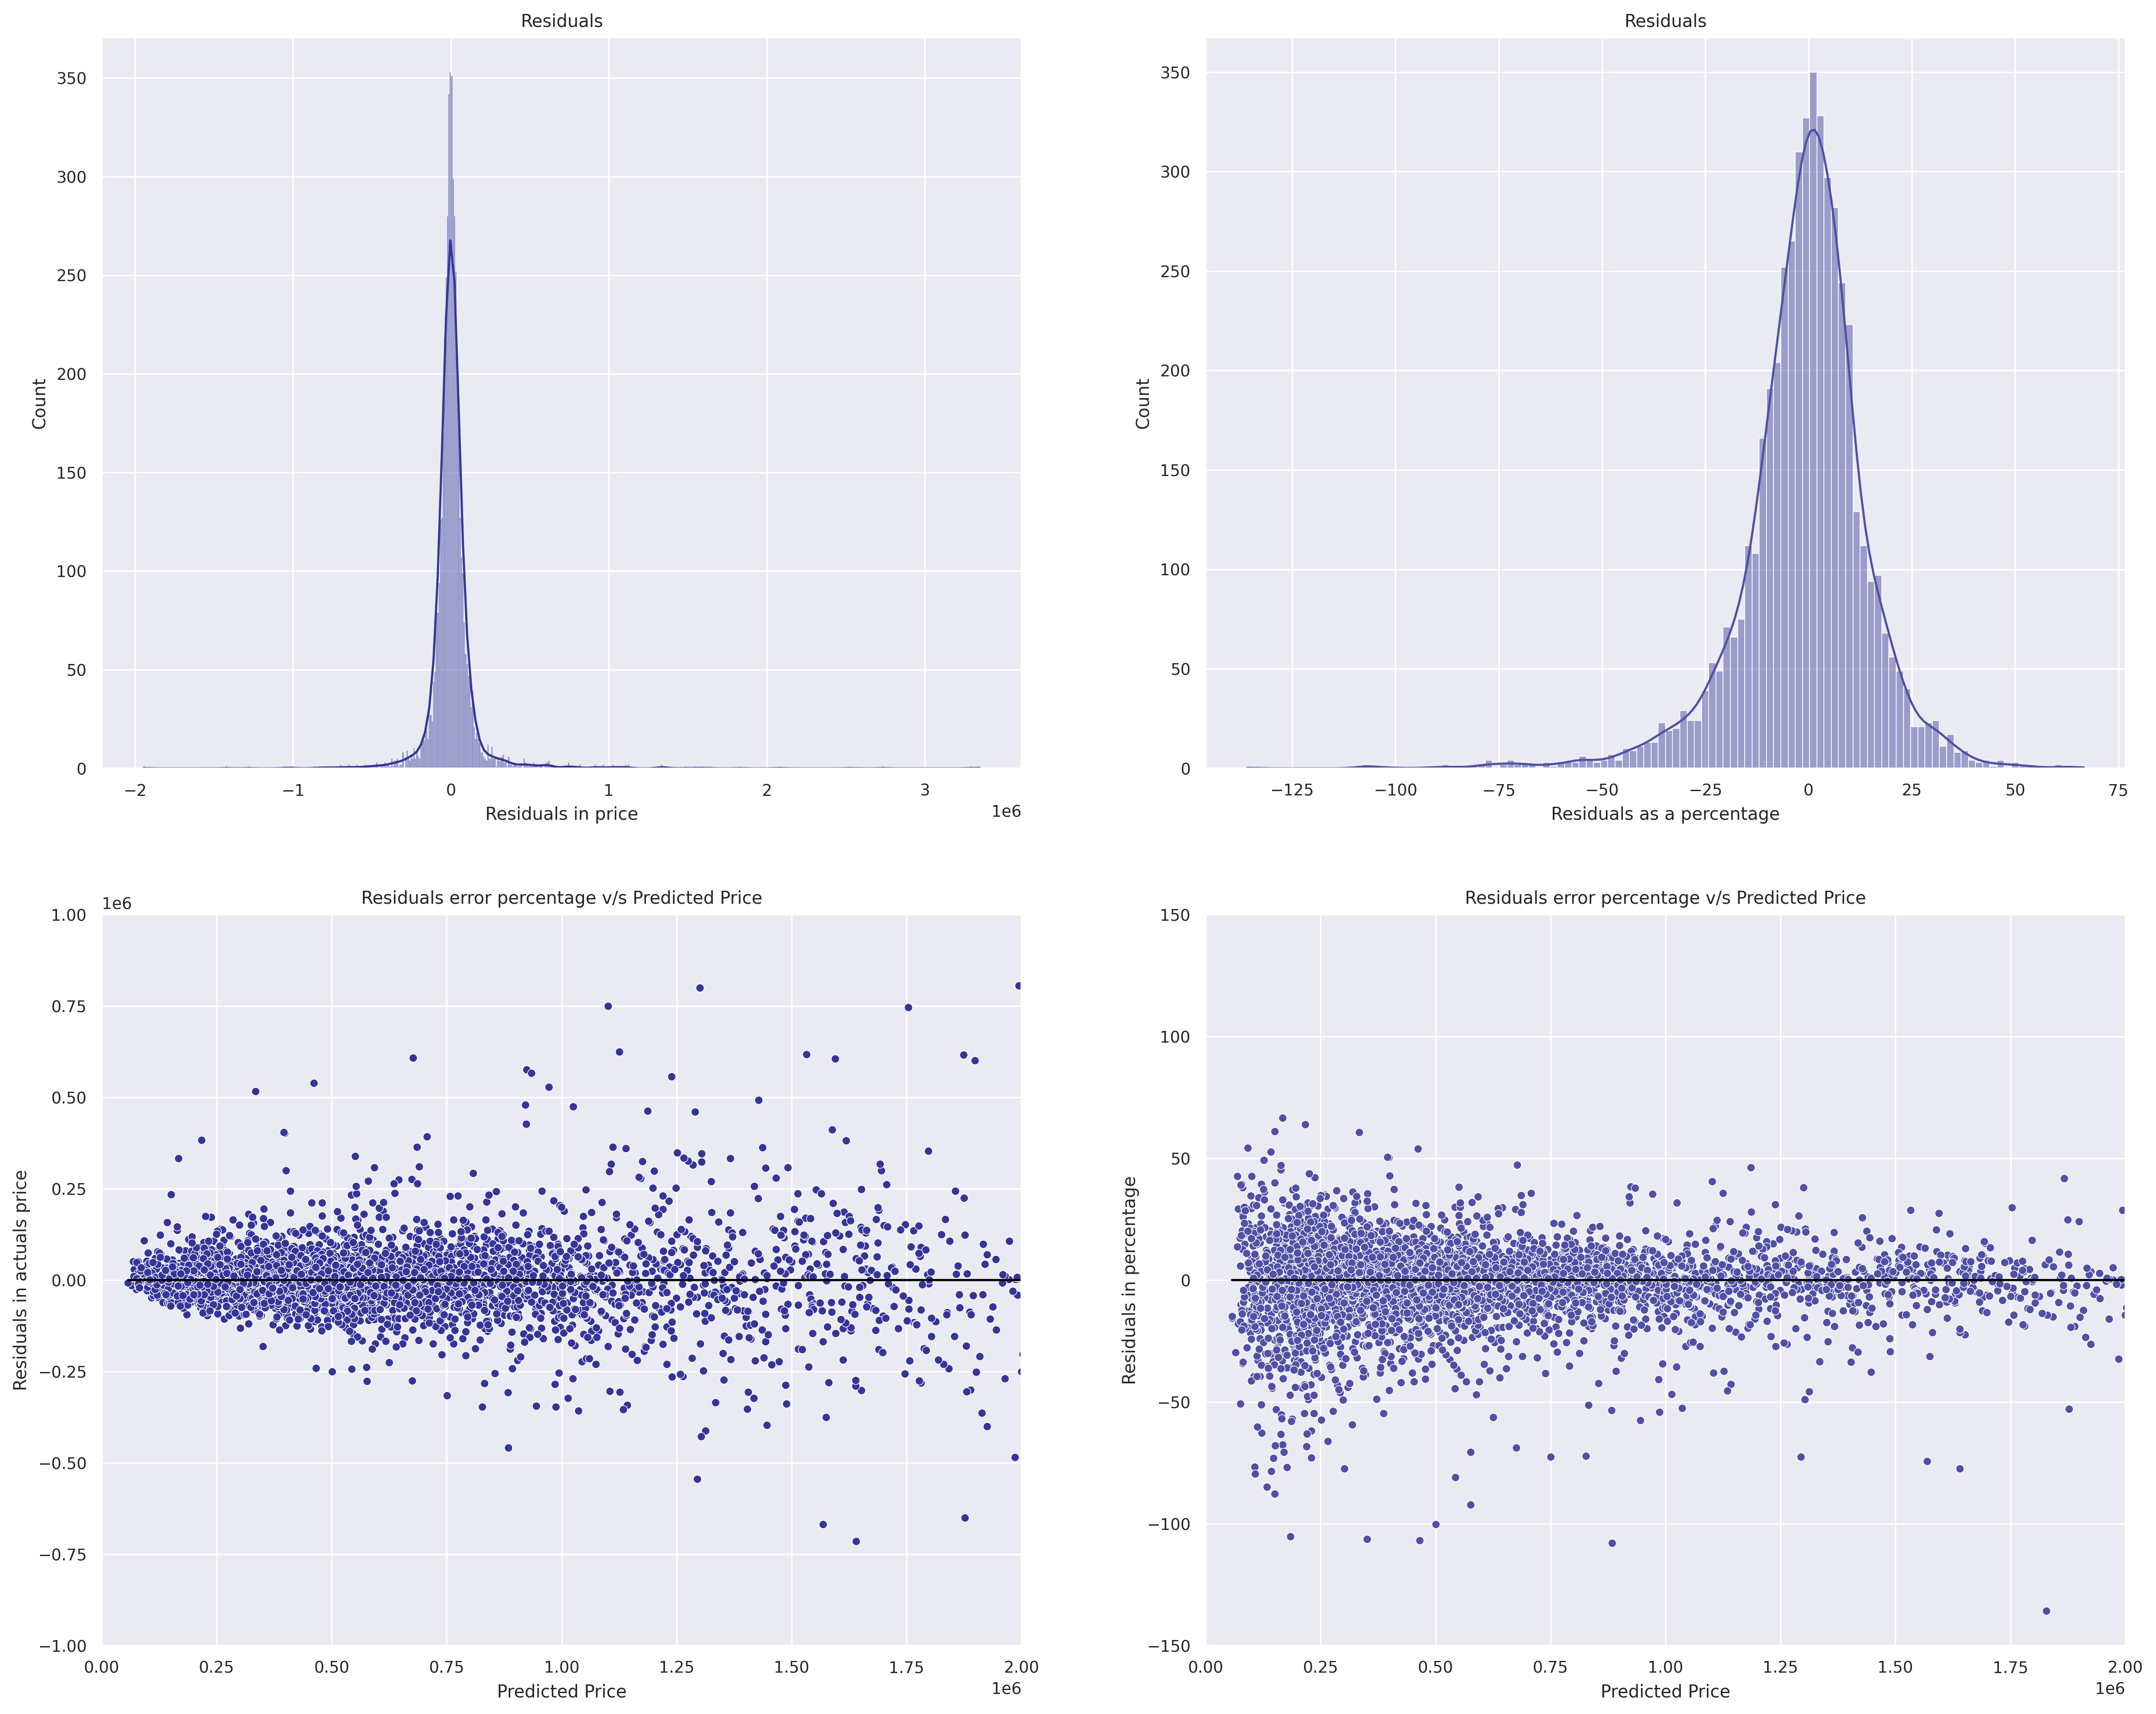

In [92]:
from matplotlib import pyplot as plt
import seaborn as sns
import random

pallete = sns.light_palette("navy", reverse=True, n_colors=10)
color1 = pallete[2]
color2 = pallete[3]

sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(2, 2, figsize=(20, 16))


# Plot the residuals in a histogram in subplot 1
plot0 = sns.histplot(x=residuals, kde=True, ax=ax[0][0], color=color1)
ax[0][0].set_title('Residuals')
ax[0][0].set_xlabel('Residuals in price')
ax[0][0].set_ylabel('Count')


# Plot the residuals percentage in a histogram in subplot 2
plot1 = sns.histplot(x=residuals_percent, kde=True, ax=ax[0][1], color=color2)
ax[0][1].set_title('Residuals')
ax[0][1].set_xlabel('Residuals as a percentage')
ax[0][1].set_ylabel('Count')


# Plot the residual along the index in a reg plot in subplot 3
plot2 = sns.scatterplot(x=y_pred, y=residuals, s=20, ax=ax[1][0], color=color1)
sns.lineplot(x=y_pred, y=0, ax=ax[1][0], color='black')
plot2.set_xlim([0, 2e6])
plot2.set_ylim([-1e6, 1e6])

ax[1][0].set_title('Residuals error percentage v/s Predicted Price')
ax[1][0].set_xlabel('Predicted Price')
ax[1][0].set_ylabel('Residuals in actuals price')


# Plot the residual along the index in a reg plot in subplot 3
plot3 = sns.scatterplot(x=y_pred, y=residuals_percent, s=20, ax=ax[1][1], color=color2)
sns.lineplot(x=y_pred, y=0, ax=ax[1][1], color='black')
plot3.set_xlim([0, 2e6])
plot3.set_ylim([-150, 150])

ax[1][1].set_title('Residuals error percentage v/s Predicted Price')
ax[1][1].set_xlabel('Predicted Price')
ax[1][1].set_ylabel('Residuals in percentage')

### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

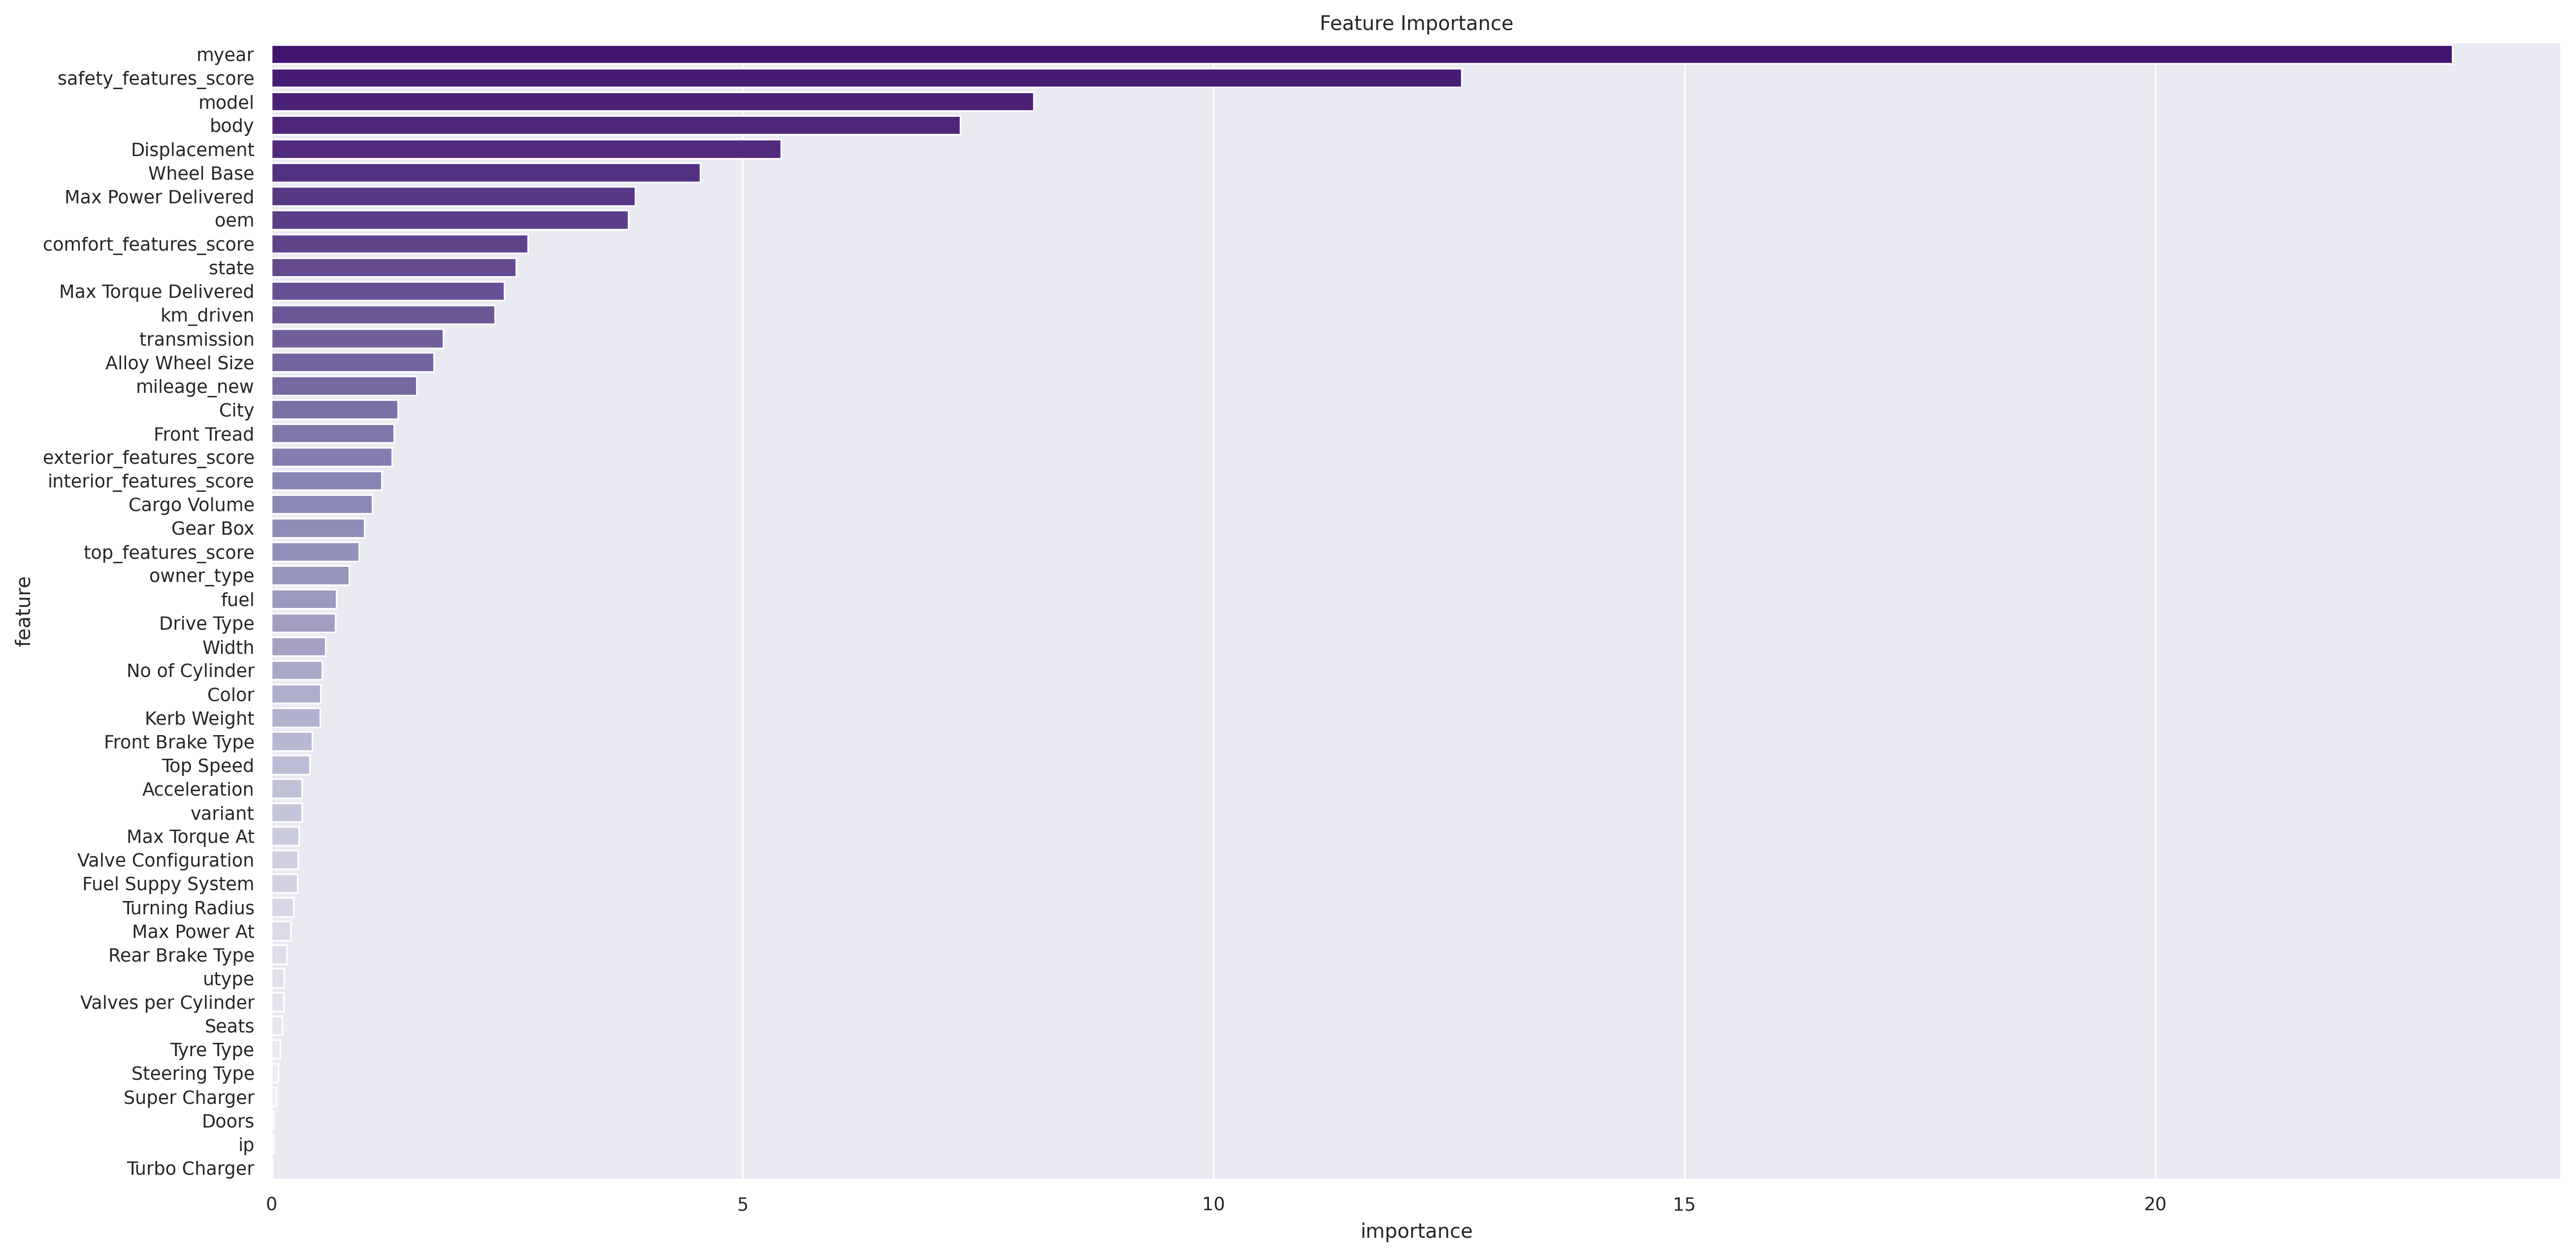

In [93]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': cb_model_mape.cb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

palette = sns.color_palette("Purples_r", n_colors=50)
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1)
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(x='importance', y='feature', data=feature_importance, palette=palette, ax=ax)
# ax.set_xticklabels(feature_importance['feature'], rotation=45, horizontalalignment='right')
ax.set_title('Feature Importance')

### SHAP interpretation

In [94]:
import shap

pool_shap_test = catboost.Pool(X_test, cat_features=[col for col in X_test.select_dtypes(include=['object', 'category']).columns])
shap_values = cb_model_mape.cb_model.get_feature_importance(pool_shap_test, type="ShapValues")

expected_value = shap_values[0,-1]
shap_value = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_value[0,:], X_test.iloc[0,:])

In [95]:
# explainer = shap.TreeExplainer(cb_model_mae_cheap.cb_model)
shap.force_plot(shap_values[0:10,-1], shap_values[0:10,:], X_test.iloc[0:10,:])

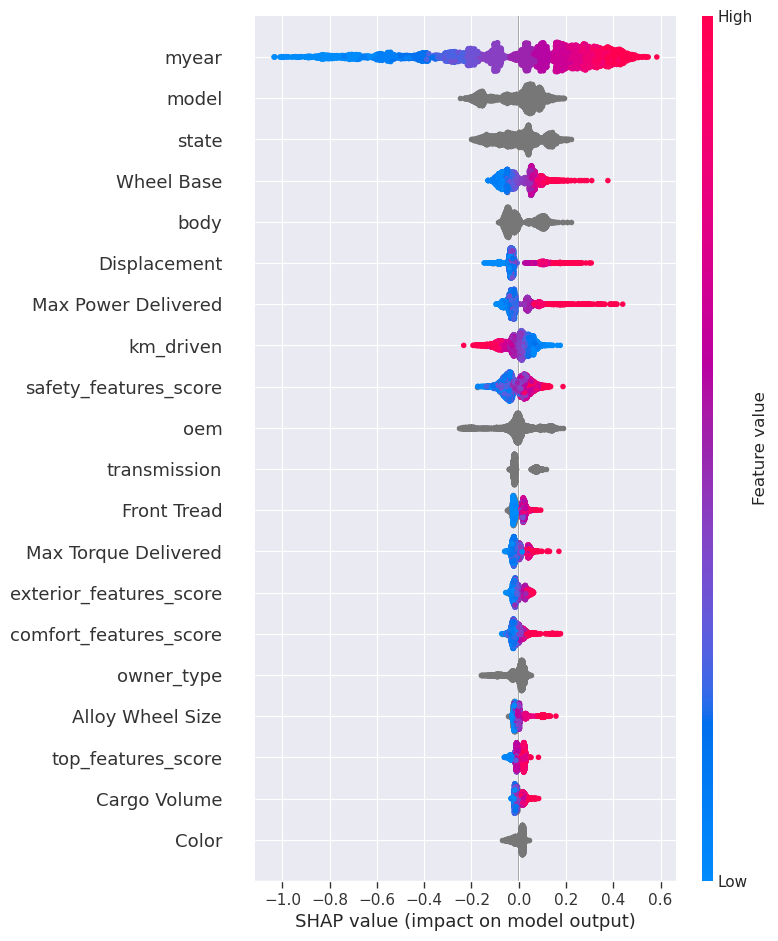

In [96]:
plt.rcParams['figure.dpi'] = 100
sns.set_style('darkgrid')
shap.summary_plot(shap_values[:,:-1], X_test)

---

# Optuna Hyper-parameter Optimization

In [8]:
import optuna
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import cross_validate

In [21]:
def objective(trial, pool_train, pool_test_for_eval, pool_test, y_test):
    param_grid = {
        "loss_function": trial.suggest_categorical("loss_function", ["MAE", "RMSE"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.8, log=True),
        "depth": trial.suggest_categorical("depth", [3,5,7,9,11,13,15]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 1, 20),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_seed": 42,
        "eval_metric": "MAE"
    }

    if param_grid["bootstrap_type"] == "Bayesian":
        param_grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param_grid["bootstrap_type"] == "Bernoulli":
        param_grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     scores = catboost.cv(
#         pool_train,
#         param_grid,
#         fold_count=3,
#         early_stopping_rounds=100,
#         verbose=100,
#     )
    cb_model = catboost.CatBoostRegressor(
        **param_grid,
        early_stopping_rounds=100,
        verbose=100,
    )
    cb_model.fit(pool_train, eval_set=pool_test_for_eval)
    preds = np.exp(cb_model.predict(pool_test))
    score = mean_absolute_percentage_error(y_test, preds)

    return score

In [ ]:
pool_train_log = catboost.Pool(X_train, np.log(y_train), cat_features=categorical_cols.to_list())
pool_test = catboost.Pool(X_test, cat_features=categorical_cols.to_list())
pool_test_for_eval = catboost.Pool(X_test, y_test, cat_features=categorical_cols.to_list())

# Define the Optuna search algorithm
study = optuna.create_study(
    direction='minimize', 
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(
      min_resource=1, max_resource=100, reduction_factor=3
    )
)
study.optimize(lambda trial: objective(trial, pool_train_log, pool_test_for_eval, pool_test, y_test), n_trials=100, timeout=None)

[I 2023-04-08 06:52:20,993] A new study created in memory with name: no-name-9b394de8-fc3c-4541-981a-e775f496eb65


0:	learn: 0.5155265	test: 772525.2546456	best: 772525.2546456 (0)	total: 80.5ms	remaining: 6m 42s
100:	learn: 0.1194823	test: 772525.2458429	best: 772525.2431657 (12)	total: 17.8s	remaining: 14m 24s


[I 2023-04-08 06:52:41,738] Trial 0 finished with value: 0.17723456002918583 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.2472010671271316, 'depth': 11, 'colsample_bylevel': 0.1185260448662222, 'l2_leaf_reg': 19.428287191077892, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.17723456002918583.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2432
bestIteration = 12

Shrink model to first 13 iterations.
0:	learn: 0.6119862	test: 772525.2800637	best: 772525.2800637 (0)	total: 281ms	remaining: 23m 23s
100:	learn: 0.1195771	test: 772525.2466950	best: 772525.2466698 (99)	total: 37.4s	remaining: 30m 14s
200:	learn: 0.0944684	test: 772525.2458619	best: 772525.2454589 (152)	total: 1m 18s	remaining: 31m 13s


[I 2023-04-08 06:54:23,984] Trial 1 finished with value: 0.12339991183716222 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.03582904732228081, 'depth': 13, 'colsample_bylevel': 0.5628109945722505, 'l2_leaf_reg': 12.255876808378806, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.12339991183716222.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2455
bestIteration = 152

Shrink model to first 153 iterations.
0:	learn: 0.6102390	test: 772525.2801263	best: 772525.2801263 (0)	total: 1.11s	remaining: 1h 32m 23s
100:	learn: 0.1053244	test: 772525.2480817	best: 772525.2480577 (99)	total: 1m 41s	remaining: 1h 22m 9s
200:	learn: 0.0780744	test: 772525.2479174	best: 772525.2473847 (142)	total: 3m 35s	remaining: 1h 25m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2474
bestIteration = 142

Shrink model to first 143 iterations.


[I 2023-04-08 06:58:51,131] Trial 2 finished with value: 0.12307888789063662 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.037993334741420026, 'depth': 15, 'colsample_bylevel': 0.3329019834400152, 'l2_leaf_reg': 13.587923402725657, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.12307888789063662.


0:	learn: 0.4323270	test: 772525.2564712	best: 772525.2564712 (0)	total: 53.7ms	remaining: 4m 28s
100:	learn: 0.1236021	test: 772525.2461113	best: 772525.2426772 (6)	total: 6.37s	remaining: 5m 8s


[I 2023-04-08 06:58:58,011] Trial 3 finished with value: 0.20521461382539685 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.5045880612021502, 'depth': 5, 'colsample_bylevel': 0.34421412859650635, 'l2_leaf_reg': 16.746012673886657, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2427
bestIteration = 6

Shrink model to first 7 iterations.
0:	learn: 0.4779876	test: 772525.2525604	best: 772525.2525604 (0)	total: 96.4ms	remaining: 8m 1s
100:	learn: 0.1305060	test: 772525.2520024	best: 772525.2457025 (12)	total: 12.5s	remaining: 10m 4s


[I 2023-04-08 06:59:12,167] Trial 4 finished with value: 0.16724293772209906 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.29488405363059905, 'depth': 7, 'colsample_bylevel': 0.4226191556898453, 'l2_leaf_reg': 3.2015121309774646, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.2518332202674705}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2457
bestIteration = 12

Shrink model to first 13 iterations.
0:	learn: 0.3862210	test: 772525.2649300	best: 772525.2649300 (0)	total: 381ms	remaining: 31m 44s
100:	learn: 0.0351236	test: 772525.2500226	best: 772525.2429246 (12)	total: 40.2s	remaining: 32m 30s


[I 2023-04-08 06:59:57,271] Trial 5 finished with value: 0.1492440006073121 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.4880290640628799, 'depth': 13, 'colsample_bylevel': 0.5704595464437947, 'l2_leaf_reg': 9.123279348812442, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5577136220482325}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2429
bestIteration = 12

Shrink model to first 13 iterations.
0:	learn: 0.6019622	test: 772525.2784518	best: 772525.2784518 (0)	total: 4.24s	remaining: 5h 53m 31s
100:	learn: 0.1331611	test: 772525.2376898	best: 772525.2349503 (56)	total: 7m 19s	remaining: 5h 55m 35s


[I 2023-04-08 07:11:42,682] Trial 6 finished with value: 0.17849342567337653 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.060394255460721885, 'depth': 13, 'colsample_bylevel': 0.6700633808593811, 'l2_leaf_reg': 17.557751213566636, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.960912999234932}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.235
bestIteration = 56

Shrink model to first 57 iterations.
0:	learn: 0.6181908	test: 772525.2800307	best: 772525.2800307 (0)	total: 55.9ms	remaining: 4m 39s
100:	learn: 0.1823960	test: 772525.2461426	best: 772525.2461426 (100)	total: 8.01s	remaining: 6m 28s
200:	learn: 0.1432645	test: 772525.2432482	best: 772525.2432015 (199)	total: 15.8s	remaining: 6m 17s
300:	learn: 0.1322046	test: 772525.2438896	best: 772525.2429964 (219)	total: 23.5s	remaining: 6m 6s


[I 2023-04-08 07:12:07,942] Trial 7 finished with value: 0.144145447677813 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.0271507059051479, 'depth': 7, 'colsample_bylevel': 0.20787883060031453, 'l2_leaf_reg': 7.414688256668931, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9746038744488646}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.243
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 0.5864341	test: 772525.2778575	best: 772525.2778575 (0)	total: 141ms	remaining: 11m 46s
100:	learn: 0.1308414	test: 772525.2440741	best: 772525.2419918 (35)	total: 17.5s	remaining: 14m 6s


[I 2023-04-08 07:12:31,657] Trial 8 finished with value: 0.18623590957930813 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.08837077274038256, 'depth': 9, 'colsample_bylevel': 0.9174392973699883, 'l2_leaf_reg': 5.551675922672476, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.616196153287175}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.242
bestIteration = 35

Shrink model to first 36 iterations.
0:	learn: 0.6074407	test: 772525.2525435	best: 772525.2525435 (0)	total: 264ms	remaining: 21m 57s
100:	learn: 0.1454197	test: 772525.2474889	best: 772525.2469404 (52)	total: 20s	remaining: 16m 11s


[I 2023-04-08 07:13:00,725] Trial 9 finished with value: 0.18065829726720542 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.05010999936771098, 'depth': 11, 'colsample_bylevel': 0.13669762739928754, 'l2_leaf_reg': 12.226965920576594, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.12307888789063662.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2469
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 0.6263996	test: 772525.2811474	best: 772525.2811474 (0)	total: 765ms	remaining: 1h 3m 42s
100:	learn: 0.2817347	test: 772525.2591017	best: 772525.2591017 (100)	total: 1m 28s	remaining: 1h 11m 26s
200:	learn: 0.1640316	test: 772525.2528567	best: 772525.2528567 (200)	total: 3m 15s	remaining: 1h 17m 38s
300:	learn: 0.1205917	test: 772525.2506531	best: 772525.2506531 (300)	total: 5m	remaining: 1h 18m 4s
400:	learn: 0.1019219	test: 772525.2498613	best: 772525.2498613 (400)	total: 6m 47s	remaining: 1h 17m 50s
500:	learn: 0.0924259	test: 772525.2490884	best: 772525.2490846 (498)	total: 8m 35s	remaining: 1h 17m 7s
600:	learn: 0.0852354	test: 772525.2489265	best: 772525.2488899 (587)	total: 10m 24s	remaining: 1h 16m 8s
700:	learn: 0.0795616	test: 772525.2489334	best: 772525.2488894 (630)	total: 12m 16s	remaining: 1h 15m 16s
Stopped by overfitting dete

[I 2023-04-08 07:25:54,118] Trial 10 finished with value: 0.12052462717803866 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.010266281747063694, 'depth': 15, 'colsample_bylevel': 0.3246627977570705, 'l2_leaf_reg': 14.248491783125274, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.12052462717803866.


0:	learn: 0.6250030	test: 772525.2811194	best: 772525.2811194 (0)	total: 904ms	remaining: 1h 15m 19s
100:	learn: 0.2398425	test: 772525.2551850	best: 772525.2551850 (100)	total: 1m 35s	remaining: 1h 17m
200:	learn: 0.1373010	test: 772525.2507515	best: 772525.2507489 (195)	total: 3m 24s	remaining: 1h 21m 23s
300:	learn: 0.1051180	test: 772525.2490391	best: 772525.2490232 (299)	total: 5m 18s	remaining: 1h 22m 46s
400:	learn: 0.0915657	test: 772525.2480478	best: 772525.2480240 (399)	total: 7m 10s	remaining: 1h 22m 11s
500:	learn: 0.0834543	test: 772525.2477215	best: 772525.2475338 (451)	total: 9m	remaining: 1h 20m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2475
bestIteration = 451

Shrink model to first 452 iterations.


[I 2023-04-08 07:35:57,480] Trial 11 finished with value: 0.12150645485824525 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012699746362719476, 'depth': 15, 'colsample_bylevel': 0.33411336893652727, 'l2_leaf_reg': 14.245962068461793, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.12052462717803866.


0:	learn: 0.6257998	test: 772525.2811416	best: 772525.2811416 (0)	total: 1.08s	remaining: 1h 29m 54s
100:	learn: 0.2682708	test: 772525.2573277	best: 772525.2573277 (100)	total: 1m 24s	remaining: 1h 8m 40s
200:	learn: 0.1548781	test: 772525.2522353	best: 772525.2522353 (200)	total: 3m 3s	remaining: 1h 13m 7s
300:	learn: 0.1154687	test: 772525.2502205	best: 772525.2502205 (300)	total: 4m 42s	remaining: 1h 13m 34s
400:	learn: 0.0984361	test: 772525.2491923	best: 772525.2491694 (395)	total: 6m 26s	remaining: 1h 13m 52s
500:	learn: 0.0893136	test: 772525.2484555	best: 772525.2484555 (500)	total: 8m 4s	remaining: 1h 12m 31s
600:	learn: 0.0824873	test: 772525.2484921	best: 772525.2482923 (574)	total: 9m 50s	remaining: 1h 11m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2483
bestIteration = 574

Shrink model to first 575 iterations.


[I 2023-04-08 07:47:02,804] Trial 12 finished with value: 0.12164411320299713 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.01091663222609512, 'depth': 15, 'colsample_bylevel': 0.29606822545270345, 'l2_leaf_reg': 14.540829565588513, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 10 with value: 0.12052462717803866.


0:	learn: 0.6255469	test: 772525.2811493	best: 772525.2811493 (0)	total: 1.5s	remaining: 2h 4m 35s
100:	learn: 0.2526133	test: 772525.2559870	best: 772525.2559870 (100)	total: 2m 2s	remaining: 1h 38m 46s
200:	learn: 0.1449701	test: 772525.2504508	best: 772525.2504508 (200)	total: 4m 15s	remaining: 1h 41m 28s
300:	learn: 0.1087810	test: 772525.2488236	best: 772525.2488115 (299)	total: 6m 34s	remaining: 1h 42m 41s
400:	learn: 0.0938971	test: 772525.2475714	best: 772525.2475639 (396)	total: 8m 51s	remaining: 1h 41m 37s
500:	learn: 0.0858896	test: 772525.2470637	best: 772525.2470465 (498)	total: 11m 4s	remaining: 1h 39m 29s
600:	learn: 0.0795520	test: 772525.2472213	best: 772525.2469347 (530)	total: 13m 31s	remaining: 1h 38m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2469
bestIteration = 530

Shrink model to first 531 iterations.


[I 2023-04-08 08:01:22,014] Trial 13 finished with value: 0.12047599224482482 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.011630944576432831, 'depth': 15, 'colsample_bylevel': 0.4301233323459711, 'l2_leaf_reg': 10.349767330154707, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.12047599224482482.


0:	learn: 0.6236894	test: 772525.2813948	best: 772525.2813948 (0)	total: 27ms	remaining: 2m 15s
100:	learn: 0.2625664	test: 772525.2535269	best: 772525.2535269 (100)	total: 2.11s	remaining: 1m 42s
200:	learn: 0.1955584	test: 772525.2442501	best: 772525.2442501 (200)	total: 4.14s	remaining: 1m 38s
300:	learn: 0.1742914	test: 772525.2418252	best: 772525.2417329 (299)	total: 6.21s	remaining: 1m 36s
400:	learn: 0.1634708	test: 772525.2412637	best: 772525.2410677 (388)	total: 8.31s	remaining: 1m 35s


[I 2023-04-08 08:01:32,461] Trial 14 finished with value: 0.16851547650405715 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.019791129336750368, 'depth': 3, 'colsample_bylevel': 0.4691795237390928, 'l2_leaf_reg': 9.8209332447502, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.12047599224482482.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2411
bestIteration = 388

Shrink model to first 389 iterations.
0:	learn: 0.6223214	test: 772525.2812630	best: 772525.2812630 (0)	total: 179ms	remaining: 14m 56s
100:	learn: 0.2004390	test: 772525.2500231	best: 772525.2500231 (100)	total: 1m 4s	remaining: 51m 50s
200:	learn: 0.1240446	test: 772525.2477709	best: 772525.2471587 (161)	total: 2m 21s	remaining: 56m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2472
bestIteration = 161

Shrink model to first 162 iterations.


[I 2023-04-08 08:04:41,127] Trial 15 finished with value: 0.1588977328831226 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.0188555010569222, 'depth': 15, 'colsample_bylevel': 0.23080785739855186, 'l2_leaf_reg': 10.988226837096722, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.159992938438486}. Best is trial 13 with value: 0.12047599224482482.


0:	learn: 0.6259125	test: 772525.2813593	best: 772525.2813593 (0)	total: 1.53s	remaining: 2h 7m 52s
100:	learn: 0.2589878	test: 772525.2571292	best: 772525.2571292 (100)	total: 2m 10s	remaining: 1h 45m 51s
200:	learn: 0.1477098	test: 772525.2513828	best: 772525.2513828 (200)	total: 4m 32s	remaining: 1h 48m 22s
300:	learn: 0.1096641	test: 772525.2497797	best: 772525.2497797 (300)	total: 6m 55s	remaining: 1h 48m 1s
400:	learn: 0.0941763	test: 772525.2486275	best: 772525.2486275 (400)	total: 9m 21s	remaining: 1h 47m 21s
500:	learn: 0.0852250	test: 772525.2482101	best: 772525.2481267 (466)	total: 11m 47s	remaining: 1h 45m 49s
600:	learn: 0.0790594	test: 772525.2479921	best: 772525.2479784 (558)	total: 14m 16s	remaining: 1h 44m 28s
700:	learn: 0.0740351	test: 772525.2480831	best: 772525.2479616 (613)	total: 16m 50s	remaining: 1h 43m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.248
bestIteration = 613

Shrink model to first 614 iterations.


[I 2023-04-08 08:21:56,425] Trial 16 finished with value: 0.1192637902597772 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.011176103257845809, 'depth': 15, 'colsample_bylevel': 0.4564071896786387, 'l2_leaf_reg': 8.40025315404497, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6243460	test: 772525.2807332	best: 772525.2807332 (0)	total: 31.1ms	remaining: 2m 35s
100:	learn: 0.2766742	test: 772525.2590946	best: 772525.2589747 (98)	total: 2.58s	remaining: 2m 5s
200:	learn: 0.2026878	test: 772525.2488368	best: 772525.2488368 (200)	total: 5.13s	remaining: 2m 2s
300:	learn: 0.1780323	test: 772525.2435180	best: 772525.2435059 (299)	total: 7.72s	remaining: 2m
400:	learn: 0.1660799	test: 772525.2421108	best: 772525.2420627 (399)	total: 10.4s	remaining: 1m 58s
500:	learn: 0.1580031	test: 772525.2423456	best: 772525.2420150 (486)	total: 13s	remaining: 1m 56s


[I 2023-04-08 08:22:11,990] Trial 17 finished with value: 0.16232234899551146 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.018011901574543493, 'depth': 3, 'colsample_bylevel': 0.6781258505255456, 'l2_leaf_reg': 1.0900622734086927, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.242
bestIteration = 486

Shrink model to first 487 iterations.
0:	learn: 0.6219870	test: 772525.2522911	best: 772525.2522911 (0)	total: 24.4ms	remaining: 2m 1s
100:	learn: 0.2126064	test: 772525.2479159	best: 772525.2474028 (57)	total: 2.19s	remaining: 1m 46s
200:	learn: 0.1674600	test: 772525.2473024	best: 772525.2470295 (177)	total: 4.42s	remaining: 1m 45s


[I 2023-04-08 08:22:18,362] Trial 18 finished with value: 0.17459871964467577 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.02180987640708897, 'depth': 5, 'colsample_bylevel': 0.4604057665049163, 'l2_leaf_reg': 7.489451803774353, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10812603022566758}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.247
bestIteration = 177

Shrink model to first 178 iterations.
0:	learn: 0.6254688	test: 772525.2808068	best: 772525.2808068 (0)	total: 115ms	remaining: 9m 37s
100:	learn: 0.2599504	test: 772525.2560210	best: 772525.2560210 (100)	total: 10.7s	remaining: 8m 39s
200:	learn: 0.1678769	test: 772525.2486850	best: 772525.2486850 (200)	total: 21s	remaining: 8m 22s
300:	learn: 0.1406937	test: 772525.2456122	best: 772525.2455680 (298)	total: 31.7s	remaining: 8m 14s
400:	learn: 0.1291321	test: 772525.2441424	best: 772525.2441080 (393)	total: 43.1s	remaining: 8m 14s
500:	learn: 0.1224726	test: 772525.2441378	best: 772525.2439715 (445)	total: 54.5s	remaining: 8m 9s


[I 2023-04-08 08:23:18,345] Trial 19 finished with value: 0.13201040895872565 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.013072591170047767, 'depth': 9, 'colsample_bylevel': 0.42997444067420487, 'l2_leaf_reg': 8.422005403681485, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3239975401707671}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.244
bestIteration = 445

Shrink model to first 446 iterations.
0:	learn: 0.6151420	test: 772525.2802513	best: 772525.2802513 (0)	total: 1.59s	remaining: 2h 12m 37s
100:	learn: 0.1164606	test: 772525.2498664	best: 772525.2497970 (94)	total: 3m 7s	remaining: 2h 31m 38s
200:	learn: 0.0828040	test: 772525.2476150	best: 772525.2474899 (181)	total: 6m 29s	remaining: 2h 35m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2475
bestIteration = 181

Shrink model to first 182 iterations.


[I 2023-04-08 08:32:43,189] Trial 20 finished with value: 0.12446060878098351 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.029879853427143766, 'depth': 15, 'colsample_bylevel': 0.6437426945510795, 'l2_leaf_reg': 6.38209768102707, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6262776	test: 772525.2812300	best: 772525.2812300 (0)	total: 1.23s	remaining: 1h 42m 39s
100:	learn: 0.2795284	test: 772525.2578116	best: 772525.2578116 (100)	total: 2m 4s	remaining: 1h 40m 22s
200:	learn: 0.1613113	test: 772525.2518822	best: 772525.2518822 (200)	total: 4m 8s	remaining: 1h 38m 51s
300:	learn: 0.1190093	test: 772525.2495829	best: 772525.2495316 (286)	total: 6m 10s	remaining: 1h 36m 26s
400:	learn: 0.1001499	test: 772525.2486536	best: 772525.2486536 (400)	total: 8m 17s	remaining: 1h 35m 11s
500:	learn: 0.0900797	test: 772525.2479160	best: 772525.2479051 (492)	total: 10m 26s	remaining: 1h 33m 43s
600:	learn: 0.0837633	test: 772525.2476313	best: 772525.2475867 (594)	total: 12m 45s	remaining: 1h 33m 19s
700:	learn: 0.0786498	test: 772525.2476480	best: 772525.2475206 (635)	total: 14m 58s	remaining: 1h 31m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2475
bestIteration = 635

Shrink model to first 636 iterations.


[I 2023-04-08 08:48:33,095] Trial 21 finished with value: 0.1205018561606789 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.010078025584946722, 'depth': 15, 'colsample_bylevel': 0.3986530937605948, 'l2_leaf_reg': 10.22059566948938, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6233943	test: 772525.2810924	best: 772525.2810924 (0)	total: 1.38s	remaining: 1h 54m 59s
100:	learn: 0.2047727	test: 772525.2547620	best: 772525.2547620 (100)	total: 2m 25s	remaining: 1h 57m 42s
200:	learn: 0.1188601	test: 772525.2503262	best: 772525.2502505 (195)	total: 4m 57s	remaining: 1h 58m 25s
300:	learn: 0.0942460	test: 772525.2489235	best: 772525.2489227 (299)	total: 7m 41s	remaining: 1h 59m 59s
400:	learn: 0.0834510	test: 772525.2483292	best: 772525.2482833 (381)	total: 10m 14s	remaining: 1h 57m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2483
bestIteration = 381

Shrink model to first 382 iterations.


[I 2023-04-08 09:01:06,549] Trial 22 finished with value: 0.12131721990381808 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.015169431105678087, 'depth': 15, 'colsample_bylevel': 0.49972601740821687, 'l2_leaf_reg': 10.135529176086886, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6235899	test: 772525.2809392	best: 772525.2809392 (0)	total: 1.4s	remaining: 1h 56m 31s
100:	learn: 0.2039764	test: 772525.2542898	best: 772525.2542898 (100)	total: 2m	remaining: 1h 37m 32s
200:	learn: 0.1199543	test: 772525.2491678	best: 772525.2491551 (198)	total: 4m 5s	remaining: 1h 37m 42s
300:	learn: 0.0947482	test: 772525.2484994	best: 772525.2483877 (292)	total: 6m 19s	remaining: 1h 38m 40s
400:	learn: 0.0838806	test: 772525.2477915	best: 772525.2477845 (398)	total: 8m 37s	remaining: 1h 38m 50s
500:	learn: 0.0758085	test: 772525.2481091	best: 772525.2477334 (409)	total: 11m	remaining: 1h 38m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2477
bestIteration = 409

Shrink model to first 410 iterations.


[I 2023-04-08 09:12:21,751] Trial 23 finished with value: 0.12033732647536875 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.015292187023718195, 'depth': 15, 'colsample_bylevel': 0.4118901009194591, 'l2_leaf_reg': 10.940447094943156, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6233910	test: 772525.2811483	best: 772525.2811483 (0)	total: 1.46s	remaining: 2h 1m 33s
100:	learn: 0.1999053	test: 772525.2539954	best: 772525.2539954 (100)	total: 2m 28s	remaining: 2h 16s
200:	learn: 0.1160993	test: 772525.2498308	best: 772525.2498308 (200)	total: 5m 8s	remaining: 2h 2m 35s
300:	learn: 0.0932553	test: 772525.2474552	best: 772525.2474344 (295)	total: 7m 48s	remaining: 2h 1m 48s
400:	learn: 0.0831585	test: 772525.2466198	best: 772525.2465912 (396)	total: 10m 28s	remaining: 2h 10s
500:	learn: 0.0746679	test: 772525.2473180	best: 772525.2465502 (408)	total: 13m 24s	remaining: 2h 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2466
bestIteration = 408

Shrink model to first 409 iterations.


[I 2023-04-08 09:26:01,561] Trial 24 finished with value: 0.12048036220665526 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.015646635408439014, 'depth': 15, 'colsample_bylevel': 0.5224831288210127, 'l2_leaf_reg': 11.445434274248344, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6183279	test: 772525.2806609	best: 772525.2806609 (0)	total: 1.06s	remaining: 1h 28m 43s
100:	learn: 0.1401875	test: 772525.2501800	best: 772525.2501800 (100)	total: 2m 1s	remaining: 1h 37m 57s
200:	learn: 0.0922087	test: 772525.2473725	best: 772525.2473725 (200)	total: 4m 12s	remaining: 1h 40m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2468
bestIteration = 251

Shrink model to first 252 iterations.


[I 2023-04-08 09:33:36,845] Trial 25 finished with value: 0.12157375317043215 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.024085926287206467, 'depth': 15, 'colsample_bylevel': 0.39289161961550134, 'l2_leaf_reg': 8.876989661402714, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6237261	test: 772525.2525525	best: 772525.2525525 (0)	total: 840ms	remaining: 1h 9m 58s
100:	learn: 0.2053553	test: 772525.2509680	best: 772525.2509680 (100)	total: 1m 18s	remaining: 1h 3m 50s
200:	learn: 0.1345034	test: 772525.2481994	best: 772525.2481434 (196)	total: 2m 49s	remaining: 1h 7m 30s
300:	learn: 0.1160753	test: 772525.2475593	best: 772525.2475593 (300)	total: 4m 23s	remaining: 1h 8m 34s
400:	learn: 0.1082577	test: 772525.2473728	best: 772525.2473251 (333)	total: 6m 1s	remaining: 1h 9m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2473
bestIteration = 333

Shrink model to first 334 iterations.


[I 2023-04-08 09:40:09,597] Trial 26 finished with value: 0.12713070486261493 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.016898046690073398, 'depth': 15, 'colsample_bylevel': 0.2484999653783721, 'l2_leaf_reg': 5.741669351909172, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6276337	test: 772525.2810401	best: 772525.2810401 (0)	total: 23.6ms	remaining: 1m 57s
100:	learn: 0.3637745	test: 772525.2639483	best: 772525.2638577 (99)	total: 1.97s	remaining: 1m 35s
200:	learn: 0.2614366	test: 772525.2549018	best: 772525.2549018 (200)	total: 4.09s	remaining: 1m 37s
300:	learn: 0.2158896	test: 772525.2482162	best: 772525.2482162 (300)	total: 5.95s	remaining: 1m 32s
400:	learn: 0.1938439	test: 772525.2445884	best: 772525.2445884 (400)	total: 7.82s	remaining: 1m 29s
500:	learn: 0.1813916	test: 772525.2428052	best: 772525.2428052 (500)	total: 9.63s	remaining: 1m 26s
600:	learn: 0.1731816	test: 772525.2420274	best: 772525.2420274 (600)	total: 11.5s	remaining: 1m 23s
700:	learn: 0.1672303	test: 772525.2417310	best: 772525.2417284 (698)	total: 13.4s	remaining: 1m 21s
800:	learn: 0.1624232	test: 772525.2415482	best: 772525.2415158 (798)	total: 15.3s	remaining: 1m 20s
900:	learn: 0.1581276	test: 772525.2415568	best: 772525.2415095 (897)	total: 17.1s	remaining: 1

[I 2023-04-08 09:40:28,824] Trial 27 finished with value: 0.1617377682049636 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.010189797775382474, 'depth': 3, 'colsample_bylevel': 0.3897749597800482, 'l2_leaf_reg': 11.344278613897865, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2415
bestIteration = 897

Shrink model to first 898 iterations.
0:	learn: 0.6197639	test: 772525.2806153	best: 772525.2806153 (0)	total: 69.1ms	remaining: 5m 45s
100:	learn: 0.2031798	test: 772525.2451163	best: 772525.2451163 (100)	total: 7.15s	remaining: 5m 46s
200:	learn: 0.1586122	test: 772525.2398818	best: 772525.2398253 (197)	total: 14.5s	remaining: 5m 45s
300:	learn: 0.1450375	test: 772525.2397902	best: 772525.2394030 (239)	total: 21.9s	remaining: 5m 42s


[I 2023-04-08 09:40:53,760] Trial 28 finished with value: 0.15786594666536272 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.024518694623760353, 'depth': 7, 'colsample_bylevel': 0.5361814856755793, 'l2_leaf_reg': 8.195497253808542, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.577344105749361}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2394
bestIteration = 239

Shrink model to first 240 iterations.
0:	learn: 0.6250534	test: 772525.2523858	best: 772525.2523858 (0)	total: 220ms	remaining: 18m 17s
100:	learn: 0.2464932	test: 772525.2482493	best: 772525.2481223 (96)	total: 19.7s	remaining: 15m 55s
200:	learn: 0.1681450	test: 772525.2474381	best: 772525.2474201 (199)	total: 39.4s	remaining: 15m 40s
300:	learn: 0.1479127	test: 772525.2478523	best: 772525.2473744 (206)	total: 56.5s	remaining: 14m 41s


[I 2023-04-08 09:41:51,654] Trial 29 finished with value: 0.1693100061741015 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.014220994113738247, 'depth': 11, 'colsample_bylevel': 0.10435595920819435, 'l2_leaf_reg': 9.30868653986478, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9574013034500731}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2474
bestIteration = 206

Shrink model to first 207 iterations.
0:	learn: 0.5464677	test: 772525.2740640	best: 772525.2740640 (0)	total: 44.1ms	remaining: 3m 40s
100:	learn: 0.1246757	test: 772525.2442491	best: 772525.2426710 (37)	total: 4s	remaining: 3m 13s


[I 2023-04-08 09:41:57,283] Trial 30 finished with value: 0.15351083187003806 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.17851502051017887, 'depth': 5, 'colsample_bylevel': 0.4937952418957632, 'l2_leaf_reg': 19.828575611949585, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2427
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 0.6237941	test: 772525.2811712	best: 772525.2811712 (0)	total: 1.46s	remaining: 2h 1m 30s
100:	learn: 0.2093241	test: 772525.2556281	best: 772525.2555805 (99)	total: 2m 23s	remaining: 1h 55m 54s
200:	learn: 0.1206399	test: 772525.2506855	best: 772525.2506752 (199)	total: 5m 2s	remaining: 2h 25s
300:	learn: 0.0952637	test: 772525.2484857	best: 772525.2484677 (299)	total: 7m 52s	remaining: 2h 2m 55s
400:	learn: 0.0843049	test: 772525.2478524	best: 772525.2476509 (386)	total: 10m 34s	remaining: 2h 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2477
bestIteration = 386

Shrink model to first 387 iterations.


[I 2023-04-08 09:55:01,523] Trial 31 finished with value: 0.12097067196013742 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.014916282203164943, 'depth': 15, 'colsample_bylevel': 0.5224888995947667, 'l2_leaf_reg': 11.325786560331899, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6239510	test: 772525.2809543	best: 772525.2809543 (0)	total: 267ms	remaining: 22m 14s
100:	learn: 0.2110630	test: 772525.2547717	best: 772525.2547717 (100)	total: 2m 50s	remaining: 2h 17m 33s
200:	learn: 0.1214602	test: 772525.2497152	best: 772525.2496542 (198)	total: 5m 54s	remaining: 2h 20m 59s
300:	learn: 0.0960969	test: 772525.2478310	best: 772525.2478310 (300)	total: 8m 57s	remaining: 2h 19m 56s
400:	learn: 0.0841499	test: 772525.2475946	best: 772525.2475121 (331)	total: 12m 7s	remaining: 2h 19m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2475
bestIteration = 331

Shrink model to first 332 iterations.


[I 2023-04-08 10:08:12,639] Trial 32 finished with value: 0.12430971758319086 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.014665230717450668, 'depth': 15, 'colsample_bylevel': 0.5898483787693918, 'l2_leaf_reg': 12.826633217929135, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6138836	test: 772525.2805384	best: 772525.2805384 (0)	total: 1.57s	remaining: 2h 10m 33s
100:	learn: 0.1141283	test: 772525.2492938	best: 772525.2492938 (100)	total: 2m 17s	remaining: 1h 50m 55s
200:	learn: 0.0825946	test: 772525.2479243	best: 772525.2474065 (156)	total: 4m 44s	remaining: 1h 53m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2474
bestIteration = 156

Shrink model to first 157 iterations.


[I 2023-04-08 10:14:25,541] Trial 33 finished with value: 0.12488719920339636 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.03235724147319933, 'depth': 15, 'colsample_bylevel': 0.4602230076063476, 'l2_leaf_reg': 12.0476446841132, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6196270	test: 772525.2807264	best: 772525.2807264 (0)	total: 1.16s	remaining: 1h 36m 45s
100:	learn: 0.1517106	test: 772525.2515382	best: 772525.2515382 (100)	total: 1m 54s	remaining: 1h 32m 27s
200:	learn: 0.0972599	test: 772525.2481456	best: 772525.2480465 (199)	total: 3m 59s	remaining: 1h 35m 22s
300:	learn: 0.0811350	test: 772525.2475312	best: 772525.2474574 (286)	total: 6m 4s	remaining: 1h 34m 57s
400:	learn: 0.0717487	test: 772525.2476256	best: 772525.2473776 (328)	total: 8m 18s	remaining: 1h 35m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2474
bestIteration = 328

Shrink model to first 329 iterations.


[I 2023-04-08 10:23:25,566] Trial 34 finished with value: 0.11934761108908479 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.02172334642266408, 'depth': 15, 'colsample_bylevel': 0.3811206904477973, 'l2_leaf_reg': 10.679245178886827, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6109494	test: 772525.2804250	best: 772525.2804250 (0)	total: 72.7ms	remaining: 6m 3s
100:	learn: 0.1388421	test: 772525.2440921	best: 772525.2440921 (100)	total: 9.82s	remaining: 7m 56s
200:	learn: 0.1171830	test: 772525.2426447	best: 772525.2425509 (145)	total: 20.2s	remaining: 8m 1s
300:	learn: 0.1070235	test: 772525.2439744	best: 772525.2425073 (206)	total: 31s	remaining: 8m 4s


[I 2023-04-08 10:23:57,510] Trial 35 finished with value: 0.12353435105217696 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.040603724791997774, 'depth': 9, 'colsample_bylevel': 0.3811352415411026, 'l2_leaf_reg': 9.917283162202144, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2425
bestIteration = 206

Shrink model to first 207 iterations.
0:	learn: 0.6224764	test: 772525.2525297	best: 772525.2525297 (0)	total: 837ms	remaining: 1h 9m 46s
100:	learn: 0.2016611	test: 772525.2467366	best: 772525.2467133 (99)	total: 1m 43s	remaining: 1h 23m 34s
100:	learn: 0.1467458	test: 772525.2539495	best: 772525.2538919 (98)	total: 2m 2s	remaining: 1h 38m 39s
200:	learn: 0.0878989	test: 772525.2503570	best: 772525.2500974 (185)	total: 4m 11s	remaining: 1h 40m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2501
bestIteration = 185

Shrink model to first 186 iterations.


[I 2023-04-08 10:34:18,711] Trial 38 finished with value: 0.15395422939455222 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.022067377553000728, 'depth': 15, 'colsample_bylevel': 0.4237083405386576, 'l2_leaf_reg': 8.936574979246629, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.836120994653585}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6258972	test: 772525.2811317	best: 772525.2811317 (0)	total: 75.3ms	remaining: 6m 16s
100:	learn: 0.2913485	test: 772525.2572571	best: 772525.2572571 (100)	total: 9.33s	remaining: 7m 32s
200:	learn: 0.1936070	test: 772525.2486968	best: 772525.2486968 (200)	total: 18.6s	remaining: 7m 22s
300:	learn: 0.1608044	test: 772525.2453522	best: 772525.2453522 (300)	total: 28.3s	remaining: 7m 21s
400:	learn: 0.1468680	test: 772525.2437596	best: 772525.2437596 (400)	total: 38.5s	remaining: 7m 21s
500:	learn: 0.1392524	test: 772525.2432888	best: 772525.2432888 (500)	total: 48.4s	remaining: 7m 14s
600:	learn: 0.1341895	test: 772525.2430693	best: 772525.2430669 (583)	total: 58.1s	remaining: 7m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2431
bestIteration = 583

Shrink model to first 584 iterations.


[I 2023-04-08 10:35:25,839] Trial 39 finished with value: 0.13779781150815248 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012020123176990081, 'depth': 7, 'colsample_bylevel': 0.3137140412629134, 'l2_leaf_reg': 7.628738904443547, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6133117	test: 772525.2521701	best: 772525.2521701 (0)	total: 273ms	remaining: 22m 47s
100:	learn: 0.1409363	test: 772525.2477884	best: 772525.2476678 (98)	total: 23.7s	remaining: 19m 9s
200:	learn: 0.1203637	test: 772525.2471744	best: 772525.2469468 (179)	total: 51.7s	remaining: 20m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2469
bestIteration = 179

Shrink model to first 180 iterations.


[I 2023-04-08 10:36:39,021] Trial 40 finished with value: 0.12902828446575884 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.03725184158084693, 'depth': 13, 'colsample_bylevel': 0.3536894851761338, 'l2_leaf_reg': 12.397087510660988, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5081274768713611}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6225532	test: 772525.2809685	best: 772525.2809685 (0)	total: 1.22s	remaining: 1h 42m
100:	learn: 0.1878550	test: 772525.2534387	best: 772525.2534387 (100)	total: 2m 12s	remaining: 1h 47m 28s
200:	learn: 0.1123286	test: 772525.2485699	best: 772525.2485669 (198)	total: 4m 37s	remaining: 1h 50m 37s
300:	learn: 0.0912396	test: 772525.2472014	best: 772525.2471897 (299)	total: 7m 8s	remaining: 1h 51m 34s
400:	learn: 0.0802998	test: 772525.2475695	best: 772525.2470843 (313)	total: 9m 39s	remaining: 1h 50m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2471
bestIteration = 313

Shrink model to first 314 iterations.


[I 2023-04-08 10:46:41,259] Trial 41 finished with value: 0.12283361412756436 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.0166519688644046, 'depth': 15, 'colsample_bylevel': 0.459226130141018, 'l2_leaf_reg': 11.311454636395226, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6248651	test: 772525.2811303	best: 772525.2811303 (0)	total: 1.59s	remaining: 2h 12m 13s
100:	learn: 0.2361472	test: 772525.2567062	best: 772525.2567062 (100)	total: 2m 40s	remaining: 2h 10m
200:	learn: 0.1338277	test: 772525.2512767	best: 772525.2512767 (200)	total: 5m 41s	remaining: 2h 16m 4s
300:	learn: 0.1023529	test: 772525.2493001	best: 772525.2492754 (299)	total: 8m 40s	remaining: 2h 15m 21s
400:	learn: 0.0890585	test: 772525.2482248	best: 772525.2481944 (397)	total: 11m 40s	remaining: 2h 13m 50s
500:	learn: 0.0813333	test: 772525.2479300	best: 772525.2479192 (498)	total: 14m 37s	remaining: 2h 11m 16s
600:	learn: 0.0753974	test: 772525.2481626	best: 772525.2479058 (510)	total: 17m 43s	remaining: 2h 9m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2479
bestIteration = 510

Shrink model to first 511 iterations.


[I 2023-04-08 11:04:45,951] Trial 42 finished with value: 0.1199023798348778 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012698565267424024, 'depth': 15, 'colsample_bylevel': 0.5727540128772223, 'l2_leaf_reg': 10.700245432283415, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6248963	test: 772525.2810607	best: 772525.2810607 (0)	total: 1.63s	remaining: 2h 16m 8s
100:	learn: 0.2346350	test: 772525.2567569	best: 772525.2567569 (100)	total: 2m 41s	remaining: 2h 10m 21s
300:	learn: 0.1014175	test: 772525.2500657	best: 772525.2500563 (299)	total: 8m 42s	remaining: 2h 16m
400:	learn: 0.0879437	test: 772525.2490213	best: 772525.2490079 (399)	total: 11m 49s	remaining: 2h 15m 42s
500:	learn: 0.0800815	test: 772525.2487402	best: 772525.2486620 (482)	total: 14m 59s	remaining: 2h 14m 41s
600:	learn: 0.0737658	test: 772525.2489425	best: 772525.2486605 (510)	total: 18m 14s	remaining: 2h 13m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2487
bestIteration = 510

Shrink model to first 511 iterations.


[I 2023-04-08 11:23:22,929] Trial 43 finished with value: 0.11999324715817022 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012849813193294713, 'depth': 15, 'colsample_bylevel': 0.5798572929836728, 'l2_leaf_reg': 9.50742037692116, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6252511	test: 772525.2812100	best: 772525.2812100 (0)	total: 1.29s	remaining: 1h 47m 47s
100:	learn: 0.2468230	test: 772525.2578149	best: 772525.2578149 (100)	total: 2m 35s	remaining: 2h 5m 56s
200:	learn: 0.1403636	test: 772525.2511567	best: 772525.2511567 (200)	total: 5m 29s	remaining: 2h 11m 12s
300:	learn: 0.1057920	test: 772525.2494865	best: 772525.2494865 (300)	total: 8m 26s	remaining: 2h 11m 49s
400:	learn: 0.0913357	test: 772525.2482020	best: 772525.2481836 (389)	total: 11m 24s	remaining: 2h 10m 50s
500:	learn: 0.0827505	test: 772525.2478438	best: 772525.2478168 (479)	total: 14m 21s	remaining: 2h 8m 53s
600:	learn: 0.0767252	test: 772525.2479752	best: 772525.2476677 (541)	total: 17m 29s	remaining: 2h 8m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2477
bestIteration = 541

Shrink model to first 542 iterations.


[I 2023-04-08 11:42:06,961] Trial 44 finished with value: 0.12036973410322435 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.011988056323821961, 'depth': 15, 'colsample_bylevel': 0.5687795431680516, 'l2_leaf_reg': 9.333962545128227, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6211031	test: 772525.2809182	best: 772525.2809182 (0)	total: 105ms	remaining: 8m 47s
100:	learn: 0.2218688	test: 772525.2550595	best: 772525.2550595 (100)	total: 10.3s	remaining: 8m 17s
200:	learn: 0.1663825	test: 772525.2453224	best: 772525.2453224 (200)	total: 21s	remaining: 8m 21s
300:	learn: 0.1504437	test: 772525.2440958	best: 772525.2439324 (290)	total: 31.7s	remaining: 8m 15s


[I 2023-04-08 11:42:48,511] Trial 45 finished with value: 0.15307950286793826 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.02162465602039283, 'depth': 5, 'colsample_bylevel': 0.6057434835078558, 'l2_leaf_reg': 8.27898871009927, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2439
bestIteration = 290

Shrink model to first 291 iterations.
0:	learn: 0.6251617	test: 772525.2810912	best: 772525.2810912 (0)	total: 1.91s	remaining: 2h 39m 5s
100:	learn: 0.2386193	test: 772525.2571402	best: 772525.2571402 (100)	total: 2m 41s	remaining: 2h 10m 24s
200:	learn: 0.1354315	test: 772525.2508803	best: 772525.2508472 (199)	total: 5m 31s	remaining: 2h 11m 58s
300:	learn: 0.1025286	test: 772525.2493639	best: 772525.2493639 (300)	total: 8m 25s	remaining: 2h 11m 37s
400:	learn: 0.0890061	test: 772525.2481120	best: 772525.2480597 (397)	total: 11m 20s	remaining: 2h 10m 2s
500:	learn: 0.0809988	test: 772525.2477513	best: 772525.2477087 (493)	total: 14m 16s	remaining: 2h 8m 11s
600:	learn: 0.0740977	test: 772525.2480300	best: 772525.2476464 (537)	total: 17m 26s	remaining: 2h 7m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2476
bestIteration = 537

Shrink model to first 538 

[I 2023-04-08 12:01:25,521] Trial 46 finished with value: 0.12058404950708938 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012383359961631186, 'depth': 15, 'colsample_bylevel': 0.5550543941810857, 'l2_leaf_reg': 6.448329122111247, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6159989	test: 772525.2800899	best: 772525.2800899 (0)	total: 352ms	remaining: 29m 21s
100:	learn: 0.1238368	test: 772525.2507609	best: 772525.2506720 (95)	total: 3m 16s	remaining: 2h 38m 37s
200:	learn: 0.0868843	test: 772525.2480547	best: 772525.2478624 (195)	total: 6m 52s	remaining: 2h 44m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2479
bestIteration = 195

Shrink model to first 196 iterations.


[I 2023-04-08 12:12:02,008] Trial 47 finished with value: 0.1206051591352946 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.029110408302510972, 'depth': 15, 'colsample_bylevel': 0.705493479508213, 'l2_leaf_reg': 13.692133466173793, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.04651670022211096}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6248172	test: 772525.2812758	best: 772525.2812758 (0)	total: 122ms	remaining: 10m 11s
100:	learn: 0.2503331	test: 772525.2556503	best: 772525.2555301 (99)	total: 13.2s	remaining: 10m 40s
200:	learn: 0.1625383	test: 772525.2478213	best: 772525.2478213 (200)	total: 26.9s	remaining: 10m 43s
300:	learn: 0.1371537	test: 772525.2444074	best: 772525.2444074 (300)	total: 40.6s	remaining: 10m 33s
400:	learn: 0.1265060	test: 772525.2431612	best: 772525.2431198 (393)	total: 54.9s	remaining: 10m 29s
500:	learn: 0.1203708	test: 772525.2429622	best: 772525.2429240 (493)	total: 1m 9s	remaining: 10m 20s


[I 2023-04-08 12:13:25,448] Trial 48 finished with value: 0.12784670179153584 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.01358955542383548, 'depth': 9, 'colsample_bylevel': 0.625391064474328, 'l2_leaf_reg': 10.570861574393462, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2429
bestIteration = 493

Shrink model to first 494 iterations.
0:	learn: 0.6215697	test: 772525.2808919	best: 772525.2808919 (0)	total: 1.49s	remaining: 2h 4m
100:	learn: 0.1737697	test: 772525.2525237	best: 772525.2525237 (100)	total: 2m 45s	remaining: 2h 14m 9s
200:	learn: 0.1036716	test: 772525.2489157	best: 772525.2489157 (200)	total: 5m 44s	remaining: 2h 17m 12s
300:	learn: 0.0854535	test: 772525.2472818	best: 772525.2472818 (300)	total: 8m 42s	remaining: 2h 15m 54s
400:	learn: 0.0757202	test: 772525.2471829	best: 772525.2469567 (332)	total: 11m 48s	remaining: 2h 15m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.247
bestIteration = 332

Shrink model to first 333 iterations.


[I 2023-04-08 12:26:15,608] Trial 49 finished with value: 0.12161557974770185 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.018236953439528157, 'depth': 15, 'colsample_bylevel': 0.5634284713021441, 'l2_leaf_reg': 9.387650835840052, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6265871	test: 772525.2812476	best: 772525.2812476 (0)	total: 330ms	remaining: 27m 28s
100:	learn: 0.3072709	test: 772525.2594464	best: 772525.2594464 (100)	total: 1m 1s	remaining: 49m 56s
200:	learn: 0.1961299	test: 772525.2517709	best: 772525.2517709 (200)	total: 2m 12s	remaining: 52m 48s
300:	learn: 0.1557401	test: 772525.2480195	best: 772525.2480195 (300)	total: 3m 21s	remaining: 52m 21s
400:	learn: 0.1397016	test: 772525.2459120	best: 772525.2459120 (400)	total: 4m 35s	remaining: 52m 38s
500:	learn: 0.1313983	test: 772525.2451363	best: 772525.2451363 (500)	total: 5m 43s	remaining: 51m 20s
600:	learn: 0.1259775	test: 772525.2446757	best: 772525.2446707 (599)	total: 6m 46s	remaining: 49m 35s
700:	learn: 0.1225668	test: 772525.2445027	best: 772525.2444906 (698)	total: 7m 42s	remaining: 47m 17s
800:	learn: 0.1196910	test: 772525.2443277	best: 772525.2443165 (799)	total: 8m 37s	remaining: 45m 11s
900:	learn: 0.1176543	test: 772525.2442427	best: 772525.2442427 (900)	total: 9m

[I 2023-04-08 12:36:36,561] Trial 50 finished with value: 0.1241000708645787 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.010333753477447033, 'depth': 11, 'colsample_bylevel': 0.4995404029106023, 'l2_leaf_reg': 15.37242084335099, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6736765586027316}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6253046	test: 772525.2810689	best: 772525.2810689 (0)	total: 256ms	remaining: 21m 18s
100:	learn: 0.2429151	test: 772525.2563806	best: 772525.2563806 (100)	total: 2m 48s	remaining: 2h 16m 32s
200:	learn: 0.1382778	test: 772525.2510431	best: 772525.2510228 (199)	total: 5m 48s	remaining: 2h 18m 35s
300:	learn: 0.1038384	test: 772525.2497578	best: 772525.2497399 (297)	total: 8m 51s	remaining: 2h 18m 10s
400:	learn: 0.0896498	test: 772525.2484841	best: 772525.2484841 (400)	total: 11m 55s	remaining: 2h 16m 45s
500:	learn: 0.0815034	test: 772525.2480901	best: 772525.2480869 (466)	total: 15m 6s	remaining: 2h 15m 43s
600:	learn: 0.0753245	test: 772525.2480433	best: 772525.2479032 (530)	total: 18m 22s	remaining: 2h 14m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2479
bestIteration = 530

Shrink model to first 531 iterations.


[I 2023-04-08 12:55:59,541] Trial 51 finished with value: 0.11967703831620641 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012207004036531976, 'depth': 15, 'colsample_bylevel': 0.5873765411136989, 'l2_leaf_reg': 9.695015966056046, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6258758	test: 772525.2813927	best: 772525.2813927 (0)	total: 45.1ms	remaining: 3m 45s
100:	learn: 0.2325518	test: 772525.2550650	best: 772525.2550650 (100)	total: 2m 42s	remaining: 2h 11m 34s
200:	learn: 0.1333099	test: 772525.2497777	best: 772525.2497777 (200)	total: 5m 42s	remaining: 2h 16m 16s
300:	learn: 0.1020418	test: 772525.2484887	best: 772525.2484887 (300)	total: 8m 44s	remaining: 2h 16m 23s
400:	learn: 0.0884202	test: 772525.2477668	best: 772525.2477668 (400)	total: 11m 54s	remaining: 2h 16m 32s
500:	learn: 0.0805468	test: 772525.2473914	best: 772525.2473839 (443)	total: 15m 3s	remaining: 2h 15m 14s
600:	learn: 0.0740621	test: 772525.2476978	best: 772525.2473621 (517)	total: 18m 19s	remaining: 2h 14m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2474
bestIteration = 517

Shrink model to first 518 iterations.


[I 2023-04-08 13:14:54,191] Trial 52 finished with value: 0.11945484884525209 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012998264640727048, 'depth': 15, 'colsample_bylevel': 0.5968460050023435, 'l2_leaf_reg': 12.24932169827044, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6249327	test: 772525.2811192	best: 772525.2811192 (0)	total: 2.08s	remaining: 2h 53m 21s
100:	learn: 0.2440049	test: 772525.2569321	best: 772525.2569321 (100)	total: 3m 6s	remaining: 2h 30m 35s
300:	learn: 0.1054642	test: 772525.2496709	best: 772525.2496709 (300)	total: 10m 14s	remaining: 2h 39m 57s
400:	learn: 0.0913336	test: 772525.2486508	best: 772525.2486508 (400)	total: 13m 53s	remaining: 2h 39m 17s
500:	learn: 0.0834058	test: 772525.2481411	best: 772525.2481411 (500)	total: 17m 33s	remaining: 2h 37m 39s
600:	learn: 0.0773202	test: 772525.2482106	best: 772525.2480966 (514)	total: 21m 14s	remaining: 2h 35m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2481
bestIteration = 514

Shrink model to first 515 iterations.


[I 2023-04-08 13:36:44,025] Trial 53 finished with value: 0.11981398674059915 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012239295369184021, 'depth': 15, 'colsample_bylevel': 0.7108855118727615, 'l2_leaf_reg': 11.935039828094421, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6236423	test: 772525.2810031	best: 772525.2810031 (0)	total: 29.6ms	remaining: 2m 27s
100:	learn: 0.2556308	test: 772525.2559834	best: 772525.2559834 (100)	total: 2.6s	remaining: 2m 6s
200:	learn: 0.1919127	test: 772525.2453270	best: 772525.2453270 (200)	total: 5.26s	remaining: 2m 5s
300:	learn: 0.1716659	test: 772525.2428076	best: 772525.2427288 (296)	total: 7.96s	remaining: 2m 4s
400:	learn: 0.1607455	test: 772525.2421220	best: 772525.2418453 (373)	total: 10.6s	remaining: 2m 2s


[I 2023-04-08 13:36:56,851] Trial 54 finished with value: 0.16635950268089642 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.02085596891936112, 'depth': 3, 'colsample_bylevel': 0.7005724539684992, 'l2_leaf_reg': 12.117669377030536, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2418
bestIteration = 373

Shrink model to first 374 iterations.
0:	learn: 0.6262914	test: 772525.2811852	best: 772525.2811852 (0)	total: 1.75s	remaining: 2h 25m 54s
100:	learn: 0.2782468	test: 772525.2590600	best: 772525.2590600 (100)	total: 3m 6s	remaining: 2h 31m 7s
200:	learn: 0.1600916	test: 772525.2530602	best: 772525.2530602 (200)	total: 6m 46s	remaining: 2h 41m 35s
300:	learn: 0.1172100	test: 772525.2505638	best: 772525.2505638 (300)	total: 10m 30s	remaining: 2h 44m 4s
400:	learn: 0.0989253	test: 772525.2491532	best: 772525.2491532 (400)	total: 14m 13s	remaining: 2h 43m 4s
500:	learn: 0.0892804	test: 772525.2481305	best: 772525.2481305 (500)	total: 18m	remaining: 2h 41m 43s
600:	learn: 0.0827143	test: 772525.2478994	best: 772525.2478277 (541)	total: 21m 49s	remaining: 2h 39m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2478
bestIteration = 541

Shrink model to first 542 ite

[I 2023-04-08 14:00:23,870] Trial 55 finished with value: 0.12163641324222964 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.01024766726252954, 'depth': 15, 'colsample_bylevel': 0.7323943290495687, 'l2_leaf_reg': 12.833774589498077, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6230971	test: 772525.2524377	best: 772525.2524377 (0)	total: 217ms	remaining: 18m 3s
100:	learn: 0.2070901	test: 772525.2489667	best: 772525.2489499 (99)	total: 3m 21s	remaining: 2h 42m 30s
200:	learn: 0.1386129	test: 772525.2463793	best: 772525.2462570 (195)	total: 7m 18s	remaining: 2h 54m 28s
300:	learn: 0.1214895	test: 772525.2459323	best: 772525.2458737 (297)	total: 11m 31s	remaining: 2h 59m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2459
bestIteration = 297

Shrink model to first 298 iterations.


[I 2023-04-08 14:15:51,343] Trial 56 finished with value: 0.1310472718777635 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.017490139775701175, 'depth': 15, 'colsample_bylevel': 0.7905903975797187, 'l2_leaf_reg': 11.807898448360593, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6257943	test: 772525.2809735	best: 772525.2809735 (0)	total: 77.9ms	remaining: 6m 29s
100:	learn: 0.2858749	test: 772525.2581801	best: 772525.2581801 (100)	total: 7.66s	remaining: 6m 11s
200:	learn: 0.1892153	test: 772525.2498243	best: 772525.2498243 (200)	total: 15.7s	remaining: 6m 15s
300:	learn: 0.1571579	test: 772525.2459606	best: 772525.2459531 (299)	total: 23.7s	remaining: 6m 9s
400:	learn: 0.1438848	test: 772525.2437860	best: 772525.2437860 (400)	total: 31.4s	remaining: 6m
500:	learn: 0.1364970	test: 772525.2434442	best: 772525.2433605 (449)	total: 39.4s	remaining: 5m 53s


[I 2023-04-08 14:16:34,984] Trial 57 finished with value: 0.14270159473021313 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.012033595483412924, 'depth': 7, 'colsample_bylevel': 0.6343875616809113, 'l2_leaf_reg': 10.682201274709312, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 16 with value: 0.1192637902597772.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2434
bestIteration = 449

Shrink model to first 450 iterations.
0:	learn: 0.6240993	test: 772525.2812557	best: 772525.2812557 (0)	total: 1.66s	remaining: 2h 18m 17s
100:	learn: 0.2087064	test: 772525.2610183	best: 772525.2610183 (100)	total: 2m 59s	remaining: 2h 24m 45s
200:	learn: 0.1121548	test: 772525.2547659	best: 772525.2547361 (199)	total: 6m 3s	remaining: 2h 24m 42s
300:	learn: 0.0799045	test: 772525.2530451	best: 772525.2530451 (300)	total: 9m 17s	remaining: 2h 25m 4s
400:	learn: 0.0635224	test: 772525.2522274	best: 772525.2521752 (398)	total: 12m 24s	remaining: 2h 22m 13s
500:	learn: 0.0523750	test: 772525.2520112	best: 772525.2519944 (461)	total: 15m 39s	remaining: 2h 20m 34s
600:	learn: 0.0445198	test: 772525.2518447	best: 772525.2517582 (585)	total: 19m 2s	remaining: 2h 19m 25s
700:	learn: 0.0387756	test: 772525.2517813	best: 772525.2516939 (667)	total: 22m 25s	remaining: 2h 17m 32s
800:	learn: 0.0344

[I 2023-04-08 14:56:09,655] Trial 58 finished with value: 0.13556306764724474 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.013710614601606545, 'depth': 15, 'colsample_bylevel': 0.607340311955915, 'l2_leaf_reg': 10.02715700804785, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.280145315838098}. Best is trial 16 with value: 0.1192637902597772.


0:	learn: 0.6231585	test: 772525.2809307	best: 772525.2809307 (0)	total: 374ms	remaining: 31m 9s
100:	learn: 0.2043794	test: 772525.2534900	best: 772525.2534900 (100)	total: 36.6s	remaining: 29m 33s
200:	learn: 0.1268789	test: 772525.2479712	best: 772525.2479578 (199)	total: 1m 15s	remaining: 30m 7s
300:	learn: 0.1064892	test: 772525.2457731	best: 772525.2457729 (299)	total: 1m 55s	remaining: 30m
400:	learn: 0.0970743	test: 772525.2453871	best: 772525.2453746 (397)	total: 2m 36s	remaining: 29m 58s
500:	learn: 0.0905162	test: 772525.2456907	best: 772525.2451928 (428)	total: 3m 17s	remaining: 29m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2452
bestIteration = 428

Shrink model to first 429 iterations.


[I 2023-04-08 14:59:41,130] Trial 59 finished with value: 0.11912179116955962 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.01600216536218588, 'depth': 13, 'colsample_bylevel': 0.551315871695678, 'l2_leaf_reg': 13.623686748970142, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6184452	test: 772525.2805074	best: 772525.2805074 (0)	total: 364ms	remaining: 30m 18s
100:	learn: 0.1497799	test: 772525.2498972	best: 772525.2498972 (100)	total: 38.5s	remaining: 31m 5s
200:	learn: 0.1071753	test: 772525.2464197	best: 772525.2463845 (197)	total: 1m 18s	remaining: 31m 4s
300:	learn: 0.0936180	test: 772525.2463348	best: 772525.2458911 (236)	total: 2m	remaining: 31m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2459
bestIteration = 236

Shrink model to first 237 iterations.


[I 2023-04-08 15:01:58,072] Trial 60 finished with value: 0.12291297389765346 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.02444563266879368, 'depth': 13, 'colsample_bylevel': 0.5351203526168732, 'l2_leaf_reg': 13.609506419412536, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6229156	test: 772525.2807410	best: 772525.2807410 (0)	total: 404ms	remaining: 33m 41s
100:	learn: 0.1965846	test: 772525.2532000	best: 772525.2532000 (100)	total: 43.5s	remaining: 35m 9s
200:	learn: 0.1231111	test: 772525.2474731	best: 772525.2474725 (197)	total: 1m 26s	remaining: 34m 27s
300:	learn: 0.1042073	test: 772525.2457942	best: 772525.2457142 (293)	total: 2m 12s	remaining: 34m 32s
400:	learn: 0.0956660	test: 772525.2453806	best: 772525.2452881 (368)	total: 2m 58s	remaining: 34m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2453
bestIteration = 368

Shrink model to first 369 iterations.


[I 2023-04-08 15:05:30,973] Trial 61 finished with value: 0.12080623106864938 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.01664219990963335, 'depth': 13, 'colsample_bylevel': 0.6351167395573594, 'l2_leaf_reg': 11.784122448660359, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6211710	test: 772525.2807401	best: 772525.2807401 (0)	total: 377ms	remaining: 31m 26s
100:	learn: 0.1746614	test: 772525.2518660	best: 772525.2518660 (100)	total: 44s	remaining: 35m 34s
200:	learn: 0.1148837	test: 772525.2470982	best: 772525.2470982 (200)	total: 1m 28s	remaining: 35m 10s
300:	learn: 0.1002402	test: 772525.2457189	best: 772525.2456986 (293)	total: 2m 15s	remaining: 35m 18s
400:	learn: 0.0913372	test: 772525.2461774	best: 772525.2456873 (308)	total: 3m 5s	remaining: 35m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2457
bestIteration = 308

Shrink model to first 309 iterations.


[I 2023-04-08 15:08:40,801] Trial 62 finished with value: 0.12138330501810916 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.019504007949819487, 'depth': 13, 'colsample_bylevel': 0.6645138120225467, 'l2_leaf_reg': 12.577352882700986, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6256659	test: 772525.2809532	best: 772525.2809532 (0)	total: 353ms	remaining: 29m 22s
100:	learn: 0.2595635	test: 772525.2563104	best: 772525.2563104 (100)	total: 40.6s	remaining: 32m 48s
200:	learn: 0.1543088	test: 772525.2501199	best: 772525.2501199 (200)	total: 1m 21s	remaining: 32m 33s
300:	learn: 0.1206568	test: 772525.2474532	best: 772525.2474532 (300)	total: 2m 2s	remaining: 31m 49s
400:	learn: 0.1069686	test: 772525.2456756	best: 772525.2456756 (400)	total: 2m 44s	remaining: 31m 25s
500:	learn: 0.0993054	test: 772525.2452288	best: 772525.2451411 (484)	total: 3m 28s	remaining: 31m 9s
600:	learn: 0.0937594	test: 772525.2450373	best: 772525.2449745 (582)	total: 4m 12s	remaining: 30m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.245
bestIteration = 582

Shrink model to first 583 iterations.


[I 2023-04-08 15:13:32,323] Trial 63 finished with value: 0.1196656423100232 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.011516170102646004, 'depth': 13, 'colsample_bylevel': 0.5929305036329554, 'l2_leaf_reg': 10.908481128532337, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6257335	test: 772525.2813337	best: 772525.2813337 (0)	total: 450ms	remaining: 37m 30s
100:	learn: 0.2646352	test: 772525.2567909	best: 772525.2567909 (100)	total: 39.4s	remaining: 31m 51s
200:	learn: 0.1568047	test: 772525.2504319	best: 772525.2504319 (200)	total: 1m 20s	remaining: 32m 13s
300:	learn: 0.1222571	test: 772525.2475991	best: 772525.2475991 (300)	total: 2m 4s	remaining: 32m 18s
400:	learn: 0.1080944	test: 772525.2460268	best: 772525.2460268 (400)	total: 2m 48s	remaining: 32m 9s
500:	learn: 0.1003015	test: 772525.2456060	best: 772525.2454790 (475)	total: 3m 31s	remaining: 31m 41s
600:	learn: 0.0949549	test: 772525.2455769	best: 772525.2454291 (562)	total: 4m 16s	remaining: 31m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2454
bestIteration = 562

Shrink model to first 563 iterations.


[I 2023-04-08 15:18:17,900] Trial 64 finished with value: 0.12039275706288294 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.01136174161008306, 'depth': 13, 'colsample_bylevel': 0.6014486870151053, 'l2_leaf_reg': 14.234106918265558, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6265571	test: 772525.2810669	best: 772525.2810669 (0)	total: 286ms	remaining: 23m 49s
100:	learn: 0.2888212	test: 772525.2580640	best: 772525.2580640 (100)	total: 33.4s	remaining: 27m
200:	learn: 0.1728771	test: 772525.2512723	best: 772525.2512723 (200)	total: 1m 7s	remaining: 26m 47s
300:	learn: 0.1313945	test: 772525.2483300	best: 772525.2483300 (300)	total: 1m 41s	remaining: 26m 30s
400:	learn: 0.1138957	test: 772525.2469702	best: 772525.2469657 (399)	total: 2m 18s	remaining: 26m 22s
500:	learn: 0.1049386	test: 772525.2459574	best: 772525.2459574 (500)	total: 2m 52s	remaining: 25m 53s
600:	learn: 0.0992512	test: 772525.2456634	best: 772525.2455936 (595)	total: 3m 31s	remaining: 25m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2456
bestIteration = 595

Shrink model to first 596 iterations.


[I 2023-04-08 15:22:26,771] Trial 65 finished with value: 0.1212485816051011 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.010038464105337512, 'depth': 13, 'colsample_bylevel': 0.49174947342690734, 'l2_leaf_reg': 11.700720809847043, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6237171	test: 772525.2809519	best: 772525.2809519 (0)	total: 195ms	remaining: 16m 15s
100:	learn: 0.2289181	test: 772525.2534270	best: 772525.2534270 (100)	total: 31.1s	remaining: 25m 8s
200:	learn: 0.1415446	test: 772525.2476821	best: 772525.2476821 (200)	total: 1m 4s	remaining: 25m 42s
300:	learn: 0.1175977	test: 772525.2451792	best: 772525.2451333 (299)	total: 1m 39s	remaining: 25m 46s
400:	learn: 0.1059126	test: 772525.2450510	best: 772525.2449162 (335)	total: 2m 14s	remaining: 25m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2449
bestIteration = 335

Shrink model to first 336 iterations.


[I 2023-04-08 15:24:55,025] Trial 66 finished with value: 0.13014826600498353 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.015101321509955386, 'depth': 13, 'colsample_bylevel': 0.5432673099997067, 'l2_leaf_reg': 11.089885931260627, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.28978763246723827}. Best is trial 59 with value: 0.11912179116955962.


0:	learn: 0.6256511	test: 772525.2814437	best: 772525.2814437 (0)	total: 43.2ms	remaining: 3m 35s
100:	learn: 0.2853590	test: 772525.2592651	best: 772525.2592192 (99)	total: 3.68s	remaining: 2m 58s
200:	learn: 0.1963658	test: 772525.2498017	best: 772525.2498017 (200)	total: 7.32s	remaining: 2m 54s
300:	learn: 0.1677285	test: 772525.2452758	best: 772525.2452758 (300)	total: 11s	remaining: 2m 51s
400:	learn: 0.1554386	test: 772525.2438486	best: 772525.2438486 (400)	total: 15.3s	remaining: 2m 55s
500:	learn: 0.1480353	test: 772525.2435774	best: 772525.2434492 (453)	total: 19.1s	remaining: 2m 51s
600:	learn: 0.1423918	test: 772525.2438124	best: 772525.2433417 (539)	total: 22.9s	remaining: 2m 47s


[I 2023-04-08 15:25:19,800] Trial 67 finished with value: 0.14798630875500857 and parameters: {'loss_function': 'MAE', 'n_estimators': 5000, 'learning_rate': 0.013843308055068696, 'depth': 5, 'colsample_bylevel': 0.43846734722770314, 'l2_leaf_reg': 13.101570009098737, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 59 with value: 0.11912179116955962.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2433
bestIteration = 539

Shrink model to first 540 iterations.
0:	learn: 0.6237193	test: 772525.2526866	best: 772525.2526866 (0)	total: 365ms	remaining: 30m 22s
100:	learn: 0.2133927	test: 772525.2506937	best: 772525.2506937 (100)	total: 34.1s	remaining: 27m 35s
200:	learn: 0.1431079	test: 772525.2485206	best: 772525.2484755 (189)	total: 1m 11s	remaining: 28m 30s
300:	learn: 0.1266646	test: 772525.2477470	best: 772525.2477470 (300)	total: 1m 51s	remaining: 29m 2s
400:	learn: 0.1203111	test: 772525.2476303	best: 772525.2475895 (337)	total: 2m 31s	remaining: 28m 56s
500:	learn: 0.1158500	test: 772525.2474146	best: 772525.2474052 (497)	total: 3m 11s	remaining: 28m 35s
600:	learn: 0.1118511	test: 772525.2471689	best: 772525.2471349 (572)	total: 3m 50s	remaining: 28m 7s
700:	learn: 0.1084849	test: 772525.2469948	best: 772525.2469535 (684)	total: 4m 28s	remaining: 27m 24s
800:	learn: 0.1055332	test: 772525.2467904	bes

[I 2023-04-08 15:31:47,755] Trial 68 finished with value: 0.11463407688655218 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.01668068891874809, 'depth': 13, 'colsample_bylevel': 0.5166916113881579, 'l2_leaf_reg': 12.231954659054988, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.11463407688655218.


0:	learn: 0.6239751	test: 772525.2524948	best: 772525.2524948 (0)	total: 3.85s	remaining: 5h 20m 40s
100:	learn: 0.2163982	test: 772525.2469223	best: 772525.2468215 (84)	total: 3m 42s	remaining: 2h 59m 38s
200:	learn: 0.1520988	test: 772525.2463829	best: 772525.2463829 (200)	total: 7m 4s	remaining: 2h 48m 52s
300:	learn: 0.1382519	test: 772525.2469387	best: 772525.2463410 (203)	total: 9m 25s	remaining: 2h 27m 6s


[I 2023-04-08 15:41:22,443] Trial 69 finished with value: 0.154774772743244 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.016248012996249183, 'depth': 13, 'colsample_bylevel': 0.5242391747790875, 'l2_leaf_reg': 10.051705453183844, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.11463407688655218.


Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2463
bestIteration = 203

Shrink model to first 204 iterations.
0:	learn: 0.6228746	test: 772525.2523405	best: 772525.2523405 (0)	total: 304ms	remaining: 25m 20s
100:	learn: 0.1982811	test: 772525.2489063	best: 772525.2489063 (100)	total: 31.6s	remaining: 25m 33s
200:	learn: 0.1391490	test: 772525.2473024	best: 772525.2472463 (195)	total: 1m 8s	remaining: 27m 25s
300:	learn: 0.1253917	test: 772525.2472941	best: 772525.2472019 (275)	total: 1m 48s	remaining: 28m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2472
bestIteration = 275

Shrink model to first 276 iterations.


[I 2023-04-08 15:43:41,366] Trial 70 finished with value: 0.13220344211964186 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.018794015651675464, 'depth': 13, 'colsample_bylevel': 0.5059364270468174, 'l2_leaf_reg': 15.224286897447257, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.11463407688655218.


0:	learn: 0.6266172	test: 772525.2526774	best: 772525.2526774 (0)	total: 359ms	remaining: 29m 53s
100:	learn: 0.2799951	test: 772525.2523698	best: 772525.2523698 (100)	total: 31.1s	remaining: 25m 6s
200:	learn: 0.1753613	test: 772525.2496963	best: 772525.2496410 (197)	total: 1m 5s	remaining: 25m 57s
300:	learn: 0.1430110	test: 772525.2482587	best: 772525.2482447 (299)	total: 1m 41s	remaining: 26m 17s
400:	learn: 0.1300846	test: 772525.2478128	best: 772525.2477682 (397)	total: 2m 18s	remaining: 26m 27s
500:	learn: 0.1238707	test: 772525.2475777	best: 772525.2475653 (496)	total: 2m 55s	remaining: 26m 12s
600:	learn: 0.1197491	test: 772525.2475823	best: 772525.2475129 (563)	total: 3m 33s	remaining: 26m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 772525.2475
bestIteration = 563

Shrink model to first 564 iterations.


[I 2023-04-08 15:47:39,236] Trial 71 finished with value: 0.12716244542235522 and parameters: {'loss_function': 'RMSE', 'n_estimators': 5000, 'learning_rate': 0.011347454644634708, 'depth': 13, 'colsample_bylevel': 0.475207610041661, 'l2_leaf_reg': 12.527422494811303, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 68 with value: 0.11463407688655218.


0:	learn: 0.6251731	test: 772525.2525125	best: 772525.2525125 (0)	total: 429ms	remaining: 35m 45s
100:	learn: 0.2413536	test: 772525.2509472	best: 772525.2509472 (100)	total: 36.4s	remaining: 29m 27s
200:	learn: 0.1549427	test: 772525.2485942	best: 772525.2485942 (200)	total: 1m 15s	remaining: 30m 2s
300:	learn: 0.1316385	test: 772525.2478700	best: 772525.2476852 (285)	total: 1m 56s	remaining: 30m 13s
